## Import dependencies

In [131]:
import io
import json
import os
import re
import unicodedata
import urllib.parse
import zipfile
from datetime import date as _date

from pathlib import Path
from typing import Iterable

import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa
import pyarrow.csv as pacsv
import pyarrow.dataset as pads
import pyarrow.fs as pafs

# Engine
import sqlalchemy as sa
from sklearn.neighbors import BallTree
from sqlalchemy import create_engine, inspect, text
from sqlalchemy.engine import Engine


In [132]:
pl.enable_string_cache()

## same structure as backfill_fourth_wave_no-creds.ipynb

In [133]:
cwd = Path.cwd()
print("Current working directory:", cwd)

Current working directory: /Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project


In [134]:
def print_tree(path: Path, prefix: str = ""):
    # Sort items so folders come first
    items = sorted(path.iterdir(), key=lambda x: (not x.is_dir(), x.name.lower()))
    pointers = ["├── "] * (len(items) - 1) + ["└── "]
    for pointer, item in zip(pointers, items):
        print(prefix + pointer + item.name)
        if item.is_dir():
            extension = "│   " if pointer == "├── " else "    "
            print_tree(item, prefix + extension)


print_tree(path=cwd / "data")

├── backfilled
├── i24.csv
└── i24.zip


In [135]:
fourth_wave_folder = Path(cwd / "data/i24")  # ! ALL this varaible need to be set manually
published_wave = fourth_wave_folder.name
OUT_DIR = Path(cwd / "data/backfilled")

In [136]:
print(fourth_wave_folder)
print(published_wave)
print(OUT_DIR)

/Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project/data/i24
i24
/Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project/data/backfilled


In [137]:
OUT_DIR.mkdir(parents=True, exist_ok=True)

### Mapping

In [138]:
## Mapping
homologated_mapping = {
    # Casas
    "Casa": "Casa",
    "Casa en condominio": "Casa en Condominio",
    "Casa en Fraccionamiento": "Casa en Condominio",
    "Condominio Horizontal": "Casa en Condominio",
    "Desarrollo-Casa": "Casa",
    "Desarrollo-Casa en condominio": "Casa en Condominio",
    "Casa - Comercial": "Casa Comercial",
    # Departamentos
    "Departamento": "Departamento",
    "Penthouse": "Departamento",
    "Loft": "Departamento",
    "Estudio": "Departamento",
    "Dúplex": "Dúplex",
    "Desarrollo-Duplex": "Dúplex",
    "Desarrollo-Apartamento": "Departamento",
    # Terrenos
    "Lote / Terreno": "Terreno",
    "Terreno": "Terreno",
    "Desarrollo-Terreno": "Terreno",
    "Terreno habitacional": "Terreno",
    "Terreno - Comercial": "Terreno Comercial",
    "Terreno comercial": "Terreno Comercial",
    "Terreno - Industrial": "Terreno Industrial",
    "Terreno industrial": "Terreno Industrial",
    # Comerciales y Oficinas
    "Tienda / Local Comercial": "Local Comercial",
    "Local - Comercial": "Local Comercial",
    "Local": "Local Comercial",
    "Lote Comercial": "Terreno Comercial",
    "Local en Centro Comercial": "Centro Comercial",
    "Desarrollo-Local Comercial": "Local Comercial",
    "Desarrollo-Local en centro comercial": "Centro Comercial",
    "Plaza - Comercial": "Centro Comercial",
    "Centro - Comercial": "Centro Comercial",
    "Oficina": "Oficina",
    "Oficina - Comercial": "Oficina",
    "Desarrollo-Oficina comercial": "Oficina",
    "Consultorio Médico": "Consultorio",
    "Consultorio - Comercial": "Consultorio",
    "Hospital - Comercial": "Hospital",
    # Bodegas y Naves Industriales
    "Nave Industrial / Bodega": "Bodega",
    "Bodega - Comercial": "Bodega",
    "Bodega comercial": "Bodega",
    "Bodega - Industrial": "Bodega Industrial",
    "Nave - Industrial": "Bodega Industrial",
    "Parque - Industrial": "Parque Industrial",
    "Fábrica - Industrial": "Fábrica Industrial",
    # Edificios
    "Edificio": "Edificio",
    "Edificio - Comercial": "Edificio Comercial",
    "Desarrollo-Edificio": "Edificio",
    # Hoteles y Entretenimiento
    "Entretenimiento / Hotel": "Hotel",
    "Hotel - Comercial": "Hotel",
    # Villas y Quintas
    "Quinta": "Quinta",
    "Rancho": "Rancho",
    "Quinta / Hacienda": "Quinta",
    "Rancho / Huerta": "Rancho",
    "Finca/Rancho": "Rancho",
    "Finca/Rancho - Comercial": "Rancho Comercial",
    "Desarrollo-Villa": "Villa",
    "Villa": "Villa",
    # Misceláneos
    "Desarrollo": "Desarrollo",
    "Cuarto": "Cuarto",
}

ordered_columns = [
    "id",
    "id_ext",
    "id_dev",
    "title",
    "description",
    "approximate_address",
    "street_name",
    "ext_number",
    "int_number",
    "neighborhood",
    "del_mun",
    "city",
    "city_area",
    "region",
    "state",
    "country",
    "zip_code",
    "lat",
    "lon",
    "property_type",
    "property_type_raw",
    "operation_type",
    "no_bedrooms",
    "no_full_bathrooms",
    "no_half_bathrooms",
    "no_parking_spaces",
    "year_built",
    "asking_price",
    "currency",
    "maintenance_fee",  # "asking_price_pesos",
    "m2_built",
    "m2_terrain",
    "m2_balconies",
    "m2_terraces",
    "m2_rooftop",
    "amenidades",
    "jacuzzi",
    "alberca",
    "gimnasio",
    "salonusosmultiples",
    "elevador",
    "asador",
    "publisher_name",
    "publisher_type",
    "source_type",  # "source",
    "source_listing_url",
    "main_development_url",
    "publication_date",
    "date_scraped",
    # "potential_duplicates", "num_pot_duplicates",
    "is_development",
    "is_remate",
]

common_columns = [
    "id",
    "title",
    "amenidades",
    "approximate_address",
    "apt_floor",
    "asking_price",
    "city",
    "city_area",
    "content",
    "country",
    "currency",
    "date_scraped",
    "del_mun",
    "ext_number",
    "int_number",
    "lat",
    "lon",
    "m2_balconies",
    "m2_built",
    "m2_rooftop",
    "m2_terraces",
    "m2_terrain",
    "main_development_url",
    "maintenance_fee",
    "neighborhood",
    "no_bedrooms",
    "no_full_bathrooms",
    "no_half_bathrooms",
    "no_parking_spaces",
    "operation_type",
    "phone_number",
    "property_type",
    "publication_date",
    "publisher_name",
    "publisher_type",
    "region",
    "source_listing_url",
    "source_type",
    "state",
    "street_name",
    "year_built",
    "zip_code",
]

tracked_fields = [
    "asking_price",
    "currency",
    "m2_built",
    "m2_terrain",
    "lat",
    "lon",
    "no_bedrooms",
    "no_full_bathrooms",
    "no_half_bathrooms",
    "no_parking_spaces",
    "year_built",
]

### EARTH CONSTANT

In [139]:
EARTH_RADIUS_KM = 6371.0

## .

<h1 style="text-align: center;">START HERE</h1>

## . set up

In [140]:
db_path = Path("test_pipeline.db")

In [141]:
engine= create_engine(f"sqlite:///{db_path}")

### local sqlite engine

In [142]:
def get_pg_engine() -> Engine:
    """
    Resolve an Engine with a convenient local SQLite debug mode.

    Priority:
    0) If USE_SQLITE is truthy -> SQLite (file path from SQLITE_DB_PATH or default under AIRFLOW_HOME/.airflow)
    1) AIRFLOW_CONN_SODACAPITAL_PG env var (full Postgres URI)
    2) Airflow BaseHook connection id from POSTGRES_CONN_ID env (default 'SODACAPITAL_PG')
    3) PostgresHook fallback
    """

    # -------------------------
    # 0) Local debug: SQLite
    # -------------------------
    use_sqlite = (os.getenv("USE_SQLITE") or "").strip().lower() in {"1", "true", "yes", "y", "on"}
    if use_sqlite:
        sqlite_path = (os.getenv("SQLITE_DB_PATH") or "").strip()
        if sqlite_path:
            db_path = Path(sqlite_path).expanduser().resolve()
        else:
            airflow_home = Path(os.getenv("AIRFLOW_HOME", str(Path.home() / "airflow"))).expanduser()
            db_path = (airflow_home / "debug_sqlite.db").resolve()

        db_path.parent.mkdir(parents=True, exist_ok=True)
        uri = f"sqlite:///{db_path}"
        eng = create_engine(uri)

        print(f"[get_pg_engine] SQLite debug mode enabled -> {db_path}")
        print("zero")
        return eng

    # -----------------------------------------
    # 1) Full URI in env (preferred in Airflow)
    # -----------------------------------------
    conn_uri = os.getenv("AIRFLOW_CONN_SODACAPITAL_PG")
    if conn_uri:
        eng = create_engine(conn_uri)
        try:
            dbname = getattr(getattr(eng, "url", None), "database", None)
            print(f"[get_pg_engine] using env URI (AIRFLOW_CONN_SODACAPITAL_PG) db='{dbname or '?'}'")
        except Exception:
            pass
        print("one")
        return eng

    # ---------------------------------------
    # 2) Airflow Connection (BaseHook lookup)
    # ---------------------------------------
    conn_id = (os.getenv("POSTGRES_CONN_ID") or "SODACAPITAL_PG").strip()
    try:
        from airflow.hooks.base import BaseHook

        conn = BaseHook.get_connection(conn_id)
        eng = create_engine(conn.get_uri())
        try:
            dbname = getattr(getattr(eng, "url", None), "database", None)
            print(f"[get_pg_engine] using Airflow BaseHook conn_id='{conn_id}' db='{dbname or '?'}'")
        except Exception:
            pass
        print("two")
        return eng
    except Exception as e:
        print(f"[get_pg_engine] BaseHook lookup failed for '{conn_id}': {e!r}")

    # -----------------------------
    # 3) PostgresHook final fallback
    # -----------------------------
    try:
        from airflow.providers.postgres.hooks.postgres import PostgresHook

        hook = PostgresHook(postgres_conn_id=conn_id)
        try:
            eng = hook.get_sqlalchemy_engine()
            print(f"[get_pg_engine] using PostgresHook.get_sqlalchemy_engine() for '{conn_id}'")
            return eng
        except Exception:
            try:
                dsn = hook.get_uri()
            except Exception as ue:
                raise RuntimeError("Could not derive a DSN from PostgresHook.") from ue
            eng = create_engine(dsn)
            print(f"[get_pg_engine] using PostgresHook.get_uri() for '{conn_id}'")
            print("three")
            return eng
    except Exception as e:
        print(f"[get_pg_engine] PostgresHook failed for '{conn_id}': {e!r}")

    raise RuntimeError(
        "Could not obtain a Postgres engine. Set AIRFLOW_CONN_SODACAPITAL_PG or configure an Airflow connection. "
        "For local exploration, set USE_SQLITE=1."
    )

In [143]:
# reading csv file 

import polars as pl
def _read_csv_lazy_2(path: str, *, dtypes= None, null_values=None) -> pl.LazyFrame:
    dtypes=dtypes if dtypes else None
    null_values=null_values or ["None", "NULL", ""]

    with open(path, "rb") as f:
        head=f.read(256* 1024)
    sep= _sniff_delimiter(head)
    def _try_read(truncate_ragged: bool) -> pl.DataFrame:
        return pl.read_csv(
            path,
            schema_overrides=dtypes,
            null_values=null_values,
            ignore_errors=False,
            low_memory=True,
            infer_schema_length=0,
            has_header=True,
            separator=sep,
            encoding="utf8-lossy",
            truncate_ragged_lines=truncate_ragged,
        )
    try:
        df= _try_read(truncate_ragged=False)
    except Exception as e1:
        try:
            print("Retrying CSV read with truncated = True")
            df= _try_read(truncate_ragged=True)
        except Exception as e2:
            raise RuntimeError(
                f"Failed to parse CSV (sep='{sep}'). Original: {e1}; Retry: {e2}"
            )
    return df.lazy()

<h3 style="text-align: center;">Engine running</h3>


In [144]:
import os, sys
print("python:", sys.executable)
print("USE_SQLITE:", os.getenv("USE_SQLITE"))
print("SQLITE_DB_PATH:", os.getenv("SQLITE_DB_PATH"))

python: /Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project/testenv/bin/python
USE_SQLITE: 1
SQLITE_DB_PATH: /Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project/.debug/test.db


In [145]:
#run once
import os
os.environ["USE_SQLITE"] = "1"
os.environ["SQLITE_DB_PATH"] = "/Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project/.debug/test.db"

In [146]:
engine = get_pg_engine()
print(engine.url)  # should show sqlite:////.../test.db

[get_pg_engine] SQLite debug mode enabled -> /Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project/.debug/test.db
zero
sqlite:////Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project/.debug/test.db


In [147]:
pd.read_sql("SELECT name FROM sqlite_master;", engine)

,name
0,__init_test


## zip context

In [148]:
def find_git_root(start: Path | None = None) -> Path:
    current = start or Path.cwd()

    for parent in [current, *current.parents]:
        if (parent / ".git").exists():
            return parent

    raise RuntimeError("Git root not found")

In [149]:
ROOT_DIR = find_git_root()
print(ROOT_DIR)

/Users/ricardosanchez/Desktop/AUSTRALIA2023-2026/ACADEMICS/INTERNSHIP/Work/Similarity_project


In [150]:
i24_file = Path(ROOT_DIR/"data/i24.zip")

In [151]:
with zipfile.ZipFile(i24_file) as z:
    name = z.namelist()[0]
    with z.open(name) as f:
        i24_data = pl.read_csv(f)

In [152]:
i24_data.head()

id,title,content,operation_type,publication_date,publisher_name,publisher_type,property_type,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count
i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,str,str,str,str,str,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64
147512097,"""Desarrollo inmobilario en vent…","""Ubicación privilegiada, lujo a…","""sale""","""2025-09-04 17:45:38""","""Juan Pablo Carrión""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",null,"""48-64""","""52-64""",null,null,null,null,"""1-2""",null,"""1-1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{""Portabicicletas"": true, ""Res…","""52 5559664501""",1,"""Temozonnorte""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",40
147512179,"""Departamento en Venta de 1 Rec…","""Departamento Ceiba – Venta en …","""sale""","""2025-09-04 17:51:30""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2290000,"""48.0""","""52.0""",null,"""En construcción""",null,1,"""1""",null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem5339""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null
147512231,"""Departamento en Venta de 2 Rec…","""Departamento Modelo Chaká – Ve…","""sale""","""2025-09-04 17:54:48""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2740000,"""64.0""","""64.0""",null,"""En construcción""",null,2,"""2""",null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem3239""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null
142923422,"""Desarrollo inmobilario en vent…","""¡Descubre tu nuevo hogar en el…","""sale""","""2024-03-06 15:40:30""","""Alberto Navarro""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",19.442652,-99.166914,"""Xolotl 47,Tlaxpana,Miguel Hida…","""MXN""",null,"""70-71""","""78-110""",null,null,null,null,"""2-2""",null,"""1-1""","""Xolotl 47""",null,null,"""Tlaxpana""",null,"""Miguel Hidalgo""","""Miguel Hidalgo""","""Ciudad de México""","""Mexico""",null,null,null,"""Tlaxpana""","""Ciudad de México""","""2025-12-15 15:58:50""","""{""Sala de basura"": true, ""Rest…","""52 5555079489""",0,"""5QDDO2""","""4""","""5.0""","""5.0""","""5.0""","""1""","""https://www.inmuebles24.com/pr…",9
142923701,"""Departamentos Nuevos Xolotl 47…","""Este increíble departamento cu…","""sale""","""2024-03-06 16:00:05""","""Alberto Navarro""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",19.442652,-99.166914,"""Xolotl 47,Tlaxpana,Miguel Hida…","""MXN""",32584

<h3 style="text-align: center;">Reading Data</h3>


In [153]:
#Setting up own dtypes in DTYPE_MAP
TEXT, F64, I64 = pl.Utf8, pl.Float64, pl.Int64

DTYPE_MAP_2 = {
    "id": I64,                    
    "title": TEXT,
    "content": TEXT,
    "operation_type": TEXT,
    "publication_date": TEXT,
    "publisher_name": TEXT,
    "publisher_type": TEXT,
    "property_type": TEXT,
    "source_type": TEXT,
    "source_listing_url": TEXT,
    "lat": F64,
    "lon": F64,
    "approximate_address": TEXT,
    "currency": TEXT,

    #-----[Float64]-------
    "asking_price": F64,
    "maintenance_fee": F64,
    "no_bedrooms": F64,
    "no_half_bathrooms": F64,
    "units_count": F64,
    "premier_broker": F64,

    #------[TEXT]--------
    "m2_built": TEXT,
    "m2_terrain": TEXT,
    "m2_balconies": TEXT,
    "m2_rooftop": TEXT,
    "m2_terraces": TEXT,
    "year_built": TEXT,
    "apt_floor": TEXT,
    "no_full_bathrooms": TEXT,
    "no_parking_spaces": TEXT,
    "rating_count": TEXT,

    "street_name": TEXT,
    "ext_number": TEXT,
    "int_number": TEXT,
    "neighborhood": TEXT,
    "zip_code": TEXT,
    "del_mun": TEXT,
    "city": TEXT,
    "state": TEXT,
    "country": TEXT,
    "city_area": TEXT,
    "region": TEXT,
    "date_scraped": TEXT,
    "amenidades": TEXT,
    "phone_number": TEXT,
    "broker_code": TEXT,
    "general_rating_b": TEXT,
    "attention_rating_b": TEXT,
    "response_time_rating_b": TEXT,
    "ad_content_rating_b": TEXT,
    "main_development_url": TEXT,
}

## .

<h2 style="text-align: center;">INITIAL EXPLORATION</h2>

## . initial data exploration

In [154]:
#total values -> 265_026
lf_raw_t1 = i24_data.lazy()
lf_raw_t1.collect().head(5)

id,title,content,operation_type,publication_date,publisher_name,publisher_type,property_type,source_type,source_listing_url,lat,lon,approximate_address,currency,asking_price,m2_built,m2_terrain,m2_balconies,year_built,apt_floor,no_bedrooms,no_full_bathrooms,no_half_bathrooms,no_parking_spaces,street_name,ext_number,int_number,neighborhood,zip_code,del_mun,city,state,country,m2_rooftop,m2_terraces,maintenance_fee,city_area,region,date_scraped,amenidades,phone_number,premier_broker,broker_code,general_rating_b,attention_rating_b,response_time_rating_b,ad_content_rating_b,rating_count,main_development_url,units_count
i64,str,str,str,str,str,str,str,str,str,f64,f64,str,str,i64,str,str,str,str,str,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str,str,str,i64
147512097,"""Desarrollo inmobilario en vent…","""Ubicación privilegiada, lujo a…","""sale""","""2025-09-04 17:45:38""","""Juan Pablo Carrión""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",null,"""48-64""","""52-64""",null,null,null,null,"""1-2""",null,"""1-1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{""Portabicicletas"": true, ""Res…","""52 5559664501""",1,"""Temozonnorte""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",40
147512179,"""Departamento en Venta de 1 Rec…","""Departamento Ceiba – Venta en …","""sale""","""2025-09-04 17:51:30""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2290000,"""48.0""","""52.0""",null,"""En construcción""",null,1,"""1""",null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem5339""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null
147512231,"""Departamento en Venta de 2 Rec…","""Departamento Modelo Chaká – Ve…","""sale""","""2025-09-04 17:54:48""","""Juan Pablo Carrión""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",21.06363,-89.603444,"""Av. Temozon 122,Temozón Norte,…","""MXN""",2740000,"""64.0""","""64.0""",null,"""En construcción""",null,2,"""2""",null,"""1""","""Av. Temozon 122""",null,null,"""Temozón Norte""",null,"""Mérida""","""Mérida""","""Yucatán""","""Mexico""",null,null,null,"""Temozón Norte""","""Yucatán""","""2025-12-15 15:58:50""","""{}""","""52 5559664501""",1,"""Demertem3239""","""4""","""4.6""","""4.3""","""4.5""","""35""","""https://www.inmuebles24.com/pr…",null
142923422,"""Desarrollo inmobilario en vent…","""¡Descubre tu nuevo hogar en el…","""sale""","""2024-03-06 15:40:30""","""Alberto Navarro""","""Inmobiliaria""","""Departamento""","""i24""","""https://www.inmuebles24.com/pr…",19.442652,-99.166914,"""Xolotl 47,Tlaxpana,Miguel Hida…","""MXN""",null,"""70-71""","""78-110""",null,null,null,null,"""2-2""",null,"""1-1""","""Xolotl 47""",null,null,"""Tlaxpana""",null,"""Miguel Hidalgo""","""Miguel Hidalgo""","""Ciudad de México""","""Mexico""",null,null,null,"""Tlaxpana""","""Ciudad de México""","""2025-12-15 15:58:50""","""{""Sala de basura"": true, ""Rest…","""52 5555079489""",0,"""5QDDO2""","""4""","""5.0""","""5.0""","""5.0""","""1""","""https://www.inmuebles24.com/pr…",9
142923701,"""Departamentos Nuevos Xolotl 47…","""Este increíble departamento cu…","""sale""","""2024-03-06 16:00:05""","""Alberto Navarro""","""Inmobiliaria""","""Desarrollo-Apartamento""","""i24""","""https://www.inmuebles24.com/pr…",19.442652,-99.166914,"""Xolotl 47,Tlaxpana,Miguel Hida…","""MXN""",32584

In [155]:
#counter of null values for visualization
nulls=lf_raw_t1.select("no_bedrooms")
nulls.null_count().collect()

no_bedrooms
u32
6889


In [156]:
#sanity check on the dtype of a given column
t0=lf_raw_t1.select("m2_terrain").collect()
t0["m2_terrain"].dtype

String

In [157]:
#Counter of frequency for different property types
ptypes=lf_raw_t1.select("property_type").collect()
ptypes.select(pl.col("property_type").value_counts(sort=True)).head(10)

property_type
struct[2]
"{""Casa"",134583}"
"{""Departamento"",105914}"
"{""Casa en condominio"",20941}"
"{""Quinta"",1246}"
"{""Rancho"",1162}"
"{""Desarrollo-Apartamento"",832}"
"{""Desarrollo-Terreno"",129}"
"{""Desarrollo-Casa"",116}"
"{""Desarrollo"",34}"


## .

<h2 style="text-align: center;">DATA HANDLING</h2>


## . run HELPER FUNCTIONS at the bottom
(before you keep going...)

## Brief note on the data transformation ahead:
    - lf_raw_t1 -> lf_std_t1: use of _standardize_one_source_lazy (helper function) & filter property_types
    - lf_std_t1 -> lf_std_t2: use of align_schema (helper function). Output in loss of data at each stage shown ahead
    - lf_std_t2 -> lf_std_t3: selecting main columns and handling of special char in m2_built and no_full_bathrooms


### Imp changes
    - m2_terrain was added
    - property_type was filtered (only the first three with highest frequencies were used)

## HELPER FUNCTIONS

In [158]:
def _infer_source_and_operation(zip_basename: str) -> tuple[str, str | None]:
    """
    Each csv file is a different source and have different types of operations.
    This function generates a mapping of sourcers and operations.
    """
    file_name = zip_basename.lower()
    if "i24" in file_name or "inmuebles24" in file_name:
        return "i24", "SALE"
    if "lamudi" in file_name:
        return "lamudi", "VENTA"
    if "remax" in file_name:
        return "remax", "VENTA"
    if "propiedades" in file_name or "propiedades.com" in file_name:
        return "propiedades", "VENTA"
    return "unknown", None


def _clean_text_expr(col: str) -> pl.Expr:
    # Use Unicode property + joiners; replace with " " (space), not ""
    EMOJI_RE = r"(?:\p{Extended_Pictographic}|\uFE0F|\u200D|\u20E3)"

    return (
        pl.col(col)
        .cast(pl.Utf8, strict=False)
        .fill_null("")
        .str.replace_all(
            EMOJI_RE, " "
        )  # changes for a space, due to same words getting fusioned (preventapreventa)
        .str.normalize("NFKD")
        .str.replace_all(r"\p{M}+", "")
        .str.to_uppercase()
        .str.replace_all(r"\s+", " ")
        .str.strip_chars()
    )


# Used in dict, prefer this structure because polars cannot (or is hard to) clean dictionaries


def clean_dict_keys(d):
    if not isinstance(d, dict):
        return {}
    cleaned_dict = {}
    for key, value in d.items():
        clean_key = unicodedata.normalize("NFKD", key).encode("ascii", "ignore").decode("utf-8")
        clean_key = re.sub(r"[^a-zA-Z0-9\s]", "", clean_key).lower().replace(" ", "_")
        cleaned_dict[clean_key] = value
    return cleaned_dict


# 2) tiny normalizer: JSON string -> normalized JSON string (same semantics as pandas)
## Function similar to pandas code
### all_sources['amenidades'] = all_sources['amenidades'].apply(lambda x: clean_dict_keys(json.loads(x)) if isinstance(x, str) and x.startswith('{') else {})
### lstrip removes leading spaces characters


def _normalize_amenidades_json(string: str) -> str:
    if isinstance(string, str) and string.lstrip().startswith("{"):
        try:
            d = json.loads(string)
            d = clean_dict_keys(d)  # <- identical normalization to pandas

            def v2s(v):
                if v is None:
                    return ""
                if isinstance(v, bool):
                    return "true" if v else "false"
                if isinstance(v, (int, float)):
                    return str(int(v)) if isinstance(v, float) and v.is_integer() else str(v)
                return str(v)

            return json.dumps({k: v2s(v) for k, v in d.items()}, ensure_ascii=False)
        except Exception:
            return "{}"
    return "{}"


def extract_development_id(col: str) -> pl.Expr:
    url = pl.col(col).cast(pl.Utf8, strict=False)

    return (
        pl.when(url.is_not_null())  # simulates `isinstance(url, str)`
        # If it is a string, then extract desarrollo id base on regex expression
        .then(
            pl.when(url.str.contains(r"inmuebles24\.com"))
            .then(url.str.extract(r"desarrollo/([^/]+)-\d+\.html", group_index=1))
            .otherwise(
                pl.when(url.str.contains(r"lamudi\.com\.mx"))
                .then(url.str.extract(r"desarrollo/([a-zA-Z0-9\-]+)$", group_index=1))
                .otherwise(pl.lit(None, dtype=pl.Utf8))
            )
        )
        # If is not string, returns None
        .otherwise(pl.lit(None, dtype=pl.Utf8))
    )


def _align_schema(lf: pl.LazyFrame, cols: list[str], dmap: dict[str, pl.DataType]) -> pl.LazyFrame:
    TEXT = pl.Utf8
    schema_set = set(lf.collect_schema().names())

    # Add missing columns as None -> why?
    missing = [column for column in cols if column not in schema_set]
    if missing:
        lf = lf.with_columns(
            [pl.lit(None, dtype=dmap.get(column, TEXT)).alias(column) for column in missing]
        )

    # Cast existing columns to mapped polar types
    casts = []
    for column in cols:
        if column in schema_set and column in dmap:
            casts.append(pl.col(column).cast(dmap[column], strict=False).alias(column))
    if casts:
        lf = lf.with_columns(casts)
    return lf.select(cols)

def find_potential_duplicates(
    dataframe: pl.DataFrame,
    radius_km: float = 0.2,
    batch_size: int = 25_000,
    show_progress: bool = False,
) -> pl.DataFrame:
    """
    Same results (as sets) as a fully vectorized version, but uses a streaming,
    batch-by-batch neighbor query to avoid building giant arrays.
    *_global are DataFrame row indices
    *_local are BallTree indices
    """
    # Why? (adds as a first column the possible repetitions)
    df = dataframe.with_row_index(name="__pos")

    # --- Prepare arrays (NumPy) ---
    lat = df.get_column("lat").cast(pl.Float64).to_numpy()
    lon = df.get_column("lon").cast(pl.Float64).to_numpy()

    has_valid_coordinates = np.isfinite(lat) & np.isfinite(lon)

    # local index (ball tree) to global index (dataframe)
    has_valid_coordinates_idx_all = np.flatnonzero(has_valid_coordinates)

    id_inner = df.schema.get("id", pl.Utf8)

    print(f"id_inner type is {id_inner}")

    list_dtype = pl.List(id_inner)

    if has_valid_coordinates_idx_all.size == 0:
        # TODO modify return to raise exception
        print(f"No valid indexes to calculate: valid ids size is {has_valid_coordinates_idx_all}")
        return df.with_columns(pl.lit([], dtype=list_dtype).alias("potential_duplicates"))

    # Take radians coordinates to BallTree
    coords_tree = np.column_stack(
        [np.radians(lat[has_valid_coordinates]), np.radians(lon[has_valid_coordinates])]
    )
    tree = BallTree(coords_tree, metric="haversine")

    # Calculate distance threshold in radians
    radius_rad = radius_km / EARTH_RADIUS_KM

    # Filter active flag
    ## TODO check
    ## Centers (active ∧ valid)
    if "is_active" in df.columns:
        is_active = df.get_column("is_active").fill_null(True).cast(pl.Boolean).to_numpy()
    else:
        is_active = np.ones(df.height, dtype=bool)

    # Filter properties for active and valid properties
    ## centers_mask
    active_and_valid_properties = is_active & has_valid_coordinates

    # Global indices of filtered properties => array of integer positions
    # centers_global
    filtered_properties = np.flatnonzero(active_and_valid_properties)

    # set all array to -1 (invalid) => lookup table
    ## BallTree needs a local index to form its queries
    ## It does this by querying inside its coordinates tree
    ## Mapping global to local
    lookup_to_balltree = np.full(df.height, -1, dtype=int)

    # For valid properties, match their position inside the ball tree
    lookup_to_balltree[has_valid_coordinates_idx_all] = np.arange(
        has_valid_coordinates_idx_all.size
    )

    # centers_local
    # one to one with centers global, but local indices
    queried_properties_balltree = lookup_to_balltree[filtered_properties]

    # Cleaning variables
    price = (
        df.get_column("asking_price").cast(pl.Float64).to_numpy()
        if "asking_price" in df.columns
        else np.full(df.height, np.nan)
    )
    m2 = (
        df.get_column("m2_built").cast(pl.Float64).to_numpy()
        if "m2_built" in df.columns
        else np.full(df.height, np.nan)
    )
    beds = (
        df.get_column("no_bedrooms").cast(pl.Float64).to_numpy()
        if "no_bedrooms" in df.columns
        else np.full(df.height, np.nan)
    )
    baths = (
        df.get_column("no_full_bathrooms").cast(pl.Float64).to_numpy()
        if "no_full_bathrooms" in df.columns
        else np.full(df.height, np.nan)
    )
    id_dev_list = (
        df.get_column("id_dev").to_list() if "id_dev" in df.columns else [None] * df.height
    )
    ids_out = df.get_column("id").to_list() if "id" in df.columns else list(range(df.height))

    def _is_null(x):
        return x is None or (isinstance(x, float) and np.isnan(x))

    # list of rows?
    results: list[list] = [[] for _ in range(df.height)] #df.height: row_count

    # tqdm does not work
    batch_starts = range(0, len(filtered_properties), batch_size)

    for start in batch_starts:
        end = min(start + batch_size, len(filtered_properties))
        filtered_properties_batch = filtered_properties[start:end]
        queried_properties_balltree_batch = queried_properties_balltree[start:end]

        # neighbors_local_by_center
        neighbors_list = tree.query_radius(
            coords_tree[queried_properties_balltree_batch], r=radius_rad
        )

        for index, neighbors in enumerate(neighbors_list):
            property_row = filtered_properties_batch[index]
            # price[property], m2[property], beds[property],  baths[property] = price[property], m2[property], beds[property], baths[property]
            # id_dev_list[property] = id_dev_list[property]

            for neighbor_index in neighbors:
                neighbor_property = has_valid_coordinates_idx_all[neighbor_index]
                if neighbor_property == property_row:
                    continue

                # Asking price
                # price[neighbor_property] = price[neighbor_property]
                if not (
                    np.isnan(price[property_row])
                    or np.isnan(price[neighbor_property])
                    or (
                        price[neighbor_property] >= price[property_row] * 0.85
                        and price[neighbor_property] <= price[property_row] * 1.15
                    )
                ):
                    continue

                # Built area
                # m2[neighbor_property] = m2[neighbor_property]
                if not (
                    np.isnan(m2[property_row])
                    or np.isnan(m2[neighbor_property])
                    or (
                        m2[neighbor_property] >= m2[property_row] * 0.95
                        and m2[neighbor_property] <= m2[property_row] * 1.05
                    )
                ):
                    continue

                # Bedrooms
                # beds[neighbor_property] = beds[neighbor_property]
                if not (
                    np.isnan(beds[property_row])
                    or np.isnan(beds[neighbor_property])
                    or (beds[property_row] == beds[neighbor_property])
                ):
                    continue

                # Bathrooms
                # baths[neighbor_property] = baths[neighbor_property]
                if not (
                    np.isnan(baths[property_row])
                    or np.isnan(baths[neighbor_property])
                    or (baths[property_row] == baths[neighbor_property])
                ):
                    continue

                # Ensure id_dev differs; otherwise skip
                # id_dev_list[neighbor_property] = id_dev_list[neighbor_property]
                if not (
                    _is_null(id_dev_list[property_row])
                    or _is_null(id_dev_list[neighbor_property])
                    or (id_dev_list[property_row] != id_dev_list[neighbor_property])
                ):
                    continue

                results[property_row].append(ids_out[neighbor_property])

    out = df.with_columns(pl.Series("potential_duplicates", results, dtype=list_dtype))
    return out


def _sniff_delimiter(sample: bytes) -> str:
    """
    Very light heuristic: pick ',' or ';' by which appears more in the sample's first lines.
    Falls back to ','.
    """
    try:
        head = sample.splitlines()[:50]
        commas = sum(line.count(b",") for line in head)
        semis = sum(line.count(b";") for line in head)
        return ";" if semis > commas else ","
    except Exception:
        return ","


def _read_csv_lazy_from_zip(
    zip_file: zipfile.ZipFile,
    file_name: str,
    *,
    dtypes: dict[str, pl.DataType] | None = None,
    null_values: list[str] | None = None,
) -> pl.LazyFrame:
    """
    Stream a CSV file out of a ZipFile and return a Polars LazyFrame
    WITHOUT loading the whole file to disk. Robust to ragged lines and delimiter variation.
    # WITHOUT loading the whole file into RAM.
    """
    dtypes = dtypes or {}
    null_values = null_values or ["None", "NULL", ""]

    with zip_file.open(file_name) as file_sniff:
        # data = file.read()
        head = file_sniff.peek(256 * 1024)

    sep = _sniff_delimiter(head)

    # sep = _sniff_delimiter(data)

    def _try_read(truncate_ragged: bool) -> pl.DataFrame:
        with zip_file.open(file_name) as file:
            return pl.read_csv(
                # BytesIO(data),
                file,
                dtypes=dtypes,  # partial dict is fine
                null_values=null_values,
                ignore_errors=True,  # skip bad rows instead of raising
                low_memory=True,
                infer_schema_length=0,  # we supplied dtypes; skip long inference
                has_header=True,
                separator=sep,
                encoding="utf8-lossy",
                truncate_ragged_lines=truncate_ragged,
            )

    try:
        df = _try_read(truncate_ragged=False)
    except Exception as e1:
        # Retry for files like lamudi_1.csv with extra fields per row
        try:
            print("Retrying csv read with ragged rows (extra fields)")
            df = _try_read(truncate_ragged=True)
        except Exception as e2:
            raise RuntimeError(
                f"Failed to parse CSV '{file_name}' (sep='{sep}'). "
                f"Original: {e1}; Retry with truncate_ragged_lines: {e2}"
            )

    return df.lazy()


def _standardize_one_source_lazy(
    lf: pl.LazyFrame,
    source_name: str,
    *,
    operation_type_upper: str | None,
    common_columns: list[str],
    log_shape: bool = False,
) -> pl.LazyFrame:
    """
    Same logic as _standardize_one_source, but starts from an existing LazyFrame
    (so we don't re-read from disk).
    """
    # subset unique IDs (if present)
    schema_names = set(lf.collect_schema().names())

    if "id" in schema_names:
        lf = lf.with_columns(pl.col("id").cast(pl.Utf8)).unique(subset=["id"])

    # drop nulls for key numeric columns
    need_non_null = [c for c in ["asking_price", "lat", "lon"] if c in schema_names]
    if need_non_null:
        lf = lf.drop_nulls(subset=need_non_null)

    # zip_code -> strip + Utf8
    if "zip_code" in schema_names:
        lf = lf.with_columns(pl.col("zip_code").cast(pl.Utf8).str.strip_chars())

    # filter operation_type if requested
    if operation_type_upper and "operation_type" in schema_names:
        lf = lf.filter(
            pl.col("operation_type").cast(pl.Utf8).str.to_uppercase() == operation_type_upper
        )

    # filter by currency/price
    if "currency" in schema_names and "asking_price" in schema_names:
        lf = lf.filter(
            (pl.col("currency").is_in(["MXN", "MXP"]) & (pl.col("asking_price") >= 500_000))
            | ((pl.col("currency") == "USD") & (pl.col("asking_price") >= 25_000))
        )

    # keep just the common columns that exist
    keep_cols = [c for c in common_columns if c in schema_names]
    if keep_cols:
        lf = lf.select(keep_cols)

    # add source
    lf = lf.with_columns(pl.lit(source_name).alias("source"))

    if log_shape:
        try:
            df_dbg = lf.collect()
            print(f"[{source_name}] shape: {df_dbg.shape}")
        except Exception as e:
            print(f"[{source_name}] could not compute shape: {e}")

    return lf


## Export data types to pandas so then posgresql can use it


def convert_to_python_native(obj):
    if isinstance(obj, dict):
        return {convert_to_python_native(k): convert_to_python_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_python_native(i) for i in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    else:
        return obj


# -----------------------------------------------------------
# Postgres connection resolution (env URI → Airflow Conn → Hook)
# -----------------------------------------------------------


def get_pg_engine() -> Engine:
    """
    Resolve a Postgres SQLAlchemy Engine in this order:
    1) AIRFLOW_CONN_SODACAPITAL_PG env var (full URI)
    2) Airflow connection id from POSTGRES_CONN_ID env (default 'SODACAPITAL_PG')
    3) PostgresHook fallback
    """

    conn_uri = os.getenv("AIRFLOW_CONN_SODACAPITAL_PG")
    if conn_uri:
        eng = create_engine(conn_uri)
        # Optional: safe debug
        try:
            url_obj = getattr(eng, "url", None)
            dbname = getattr(url_obj, "database", None)
            print(
                f"[get_pg_engine] using env URI (AIRFLOW_CONN_SODACAPITAL_PG) for database='{dbname or '?'}'"
            )
        except Exception:
            pass
        return eng

    # 2) Try Airflow connection by ID (same as backup())
    conn_id = (os.getenv("POSTGRES_CONN_ID") or "SODACAPITAL_PG").strip()
    try:
        from airflow.hooks.base import BaseHook

        conn = BaseHook.get_connection(conn_id)
        eng = create_engine(conn.get_uri())
        # Optional: safe debug
        try:
            url_obj = getattr(eng, "url", None)
            dbname = getattr(url_obj, "database", None)
            print(
                f"[get_pg_engine] using Airflow BaseHook connection id='{conn_id}' for database='{dbname or '?'}'"
            )
        except Exception:
            pass
        return eng
    except Exception as e:
        print(f"[get_pg_engine] BaseHook lookup failed for '{conn_id}': {e!r}")

    # 3) Final fallback: PostgresHook (same spirit as backup())
    try:
        from airflow.providers.postgres.hooks.postgres import PostgresHook

        hook = PostgresHook(postgres_conn_id=conn_id)
        try:
            eng = hook.get_sqlalchemy_engine()
            print(f"[get_pg_engine] using PostgresHook.get_sqlalchemy_engine() for '{conn_id}'")
            return eng
        except Exception:
            # Some provider versions expose only a DSN/URI—build an Engine from it
            try:
                dsn = hook.get_uri()  # Airflow ≥ 2.9
            except Exception as ue:
                raise RuntimeError("Could not derive a DSN from PostgresHook.") from ue
            eng = create_engine(dsn)
            print(f"[get_pg_engine] using PostgresHook.get_uri() for '{conn_id}'")
            return eng
    except Exception as e:
        print(f"[get_pg_engine] PostgresHook failed for '{conn_id}': {e!r}")

    # If we reach here, we failed every path
    raise RuntimeError("Could not obtain a Postgres connection/engine")


# -----------------------------------------------------------
# Small helpers
# -----------------------------------------------------------
def get_table_columns(engine: Engine, schema: str, table: str) -> list[str]:
    with engine.begin() as c:
        rows = c.execute(
            text(
                """
            SELECT column_name
            FROM information_schema.columns
            WHERE table_schema=:s AND table_name=:t
            ORDER BY ordinal_position
        """
            ),
            {"s": schema, "t": table},
        ).all()
    return [r[0] for r in rows]


def ensure_table_exists(engine: Engine, schema: str, table: str) -> None:
    with engine.begin() as c:
        ok = c.execute(
            text(
                """
            SELECT EXISTS (
              SELECT 1 FROM information_schema.tables
              WHERE table_schema=:s AND table_name=:t
            )
        """
            ),
            {"s": schema, "t": table},
        ).scalar()
        if not ok:
            raise RuntimeError(f"Destination table not found: {schema}.{table}")


def ensure_tables_exist_or_clone(
    engine: Engine,
    *,
    staging_schema: str,
    table_pairs: list[tuple[str, str]],
    template_schema: str | None = None,
) -> None:
    template_schema = template_schema or staging_schema
    for staging_table, template_table in table_pairs:
        if staging_table == template_table:
            ensure_table_exists(engine, staging_schema, staging_table)
            continue
        with engine.connect() as c:
            exists = c.execute(
                text(
                    """
                SELECT EXISTS (
                  SELECT 1 FROM information_schema.tables
                  WHERE table_schema=:s AND table_name=:t
                )
            """
                ),
                {"s": staging_schema, "t": staging_table},
            ).scalar()
        if exists:
            continue
        ensure_table_exists(engine, template_schema, template_table)
        print(
            f"Creating staging table {staging_schema}.{staging_table} LIKE {template_schema}.{template_table}"
        )
        with engine.begin() as c:
            c.execute(
                text(
                    f'CREATE TABLE "{staging_schema}"."{staging_table}" '
                    f'(LIKE "{template_schema}"."{template_table}" INCLUDING ALL)'
                )
            )


def parse_fqn(fqn: str) -> tuple[str, str]:
    if "." in fqn:
        s, t = fqn.split(".", 1)
        return s, t
    return "public", fqn


# -----------------------------------------------------------
# Bounded-memory streamer from Parquet(S3) → Postgres COPY
# -----------------------------------------------------------
def upload_large_parquet_streaming(
    s3_url: str,  # "s3://bucket/path/to/file.parquet" or a prefix with many files
    target_fqn: str,  # "schema.table"
    *,
    engine: Engine,
    aws_conn_id: str | None = None,
    batch_rows: int = 128_000,  # Arrow batch; tune 64k–256k
    csv_chunk_bytes: int,  # ~4MB chunks over the COPY socket
    include_header: bool = False,
) -> int:
    """
    Streams Parquet from S3 in Arrow record batches and pipes small CSV chunks
    into Postgres COPY. Memory stays ~O(batch) + O(csv_chunk_bytes).
    Returns -1 (rowcount unknown).
    """
    # Build S3 filesystem (use Airflow creds if available)
    s3fs_kwargs = {}
    # if aws_conn_id and S3Hook is not None:
    #     hook = S3Hook(aws_conn_id=aws_conn_id)
    #     sess = hook.get_session()
    #     creds = hook.get_credentials()
    #     s3fs_kwargs = dict(
    #         access_key=creds.access_key,
    #         secret_key=creds.secret_key,
    #         session_token=getattr(creds, "token", None),
    #         region=sess.region_name or "us-east-1",
    #     )
    s3fs_kwargs.setdefault("connect_timeout", 60.0)
    s3fs_kwargs.setdefault("request_timeout", 600.0)
    s3fs = pafs.S3FileSystem(**s3fs_kwargs)

    schema, table = parse_fqn(target_fqn)
    ensure_table_exists(engine, schema, table)
    cols = get_table_columns(engine, schema, table)
    if not cols:
        raise RuntimeError(f"No columns in destination table: {schema}.{table}")

    # Generator: Arrow → CSV text chunks
    def csv_chunks() -> Iterable[bytes]:
        dataset_path = s3_url
        parsed = urllib.parse.urlparse(s3_url)
        if parsed.scheme == "s3":
            key = parsed.path.lstrip("/")
            dataset_path = parsed.netloc if not key else f"{parsed.netloc}/{key}"
        ds = pads.dataset(dataset_path, filesystem=s3fs, format="parquet")
        scanner = ds.scanner(batch_size=batch_rows)

        first = True
        for rb in scanner.to_batches():
            tbl = pa.Table.from_batches([rb])

            # add missing cols as nulls, order exactly like destination
            missing = [c for c in cols if c not in tbl.column_names]
            for m in missing:
                tbl = tbl.append_column(m, pa.nulls(len(tbl)))
            tbl = tbl.select(cols)

            sink = io.BytesIO()
            pacsv.write_csv(
                tbl,
                sink,
                write_options=pacsv.WriteOptions(include_header=(include_header and first)),
            )
            first = False
            # buf = sink.getvalue().decode("utf-8")
            buf = sink.getvalue()

            mv = memoryview(buf)  # zero-copy slicing

            # yield in steady, smaller chunks
            for i in range(0, len(buf), csv_chunk_bytes):
                # yield buf[i:i+csv_chunk_bytes]
                yield mv[i : i + csv_chunk_bytes]

    # class IterableTextIO(io.TextIOBase):
    class IterableBytesIO(io.RawIOBase):
        """
        A file-like object that serves bytes produced by an iterator.
        Psycopg2's copy_expert() will call read() repeatedly until EOF.
        """

        # def __init__(self, it: Iterable[str]):
        #     self._it = iter(it)
        #     self._cache = ""

        def __init__(self, it):
            self._it = iter(it)  # iterator of bytes-like chunks
            self._buf = bytearray()

        def readable(self):
            return True

        # def read(self, n: Optional[int] = None) -> str:
        #     # psycopg2 calls read(None) or read(small_n); serve from a small cache
        #     if n is None:
        #         # drain the iterator fully (COPY completes on EOF)
        #         buf = [self._cache]
        #         self._cache = ""
        #         buf.extend(list(self._it))
        #         return "".join(buf)
        #     # Serve exactly up to n bytes
        #     while len(self._cache) < n:
        #         try:
        #             self._cache += next(self._it)
        #         except StopIteration:
        #             break
        #     out, self._cache = self._cache[:n], self._cache[n:]
        #     return out

        def read(self, n=-1):
            # drain all if n < 0
            if n is None or n < 0:
                for chunk in self._it:
                    self._buf += chunk
                out = bytes(self._buf)
                self._buf.clear()
                return out

            # ensure we have >= n bytes buffered (or hit EOF)
            while len(self._buf) < n:
                try:
                    self._buf += next(self._it)
                except StopIteration:
                    break
            out = bytes(self._buf[:n])
            del self._buf[:n]
            return out

        def readinto(self, b):
            # fill the provided writable bytes-like buffer 'b'
            n = len(b)
            if n == 0:
                return 0
            # ensure we have at least n bytes buffered
            while len(self._buf) < n:
                try:
                    self._buf += next(self._it)
                except StopIteration:
                    break
            to_copy = min(n, len(self._buf))
            b[:to_copy] = self._buf[:to_copy]
            del self._buf[:to_copy]
            return to_copy or 0  # 0 signals EOF to callers

    collist = ", ".join(f'"{c}"' for c in cols)
    copy_sql = (
        f'COPY "{schema}"."{table}" ({collist}) FROM STDIN WITH (FORMAT csv, HEADER false)'  # TODO
    )

    with engine.begin() as conn:
        # defensive knobs for long COPY
        conn.execute(text("SET LOCAL statement_timeout='0'"))
        conn.execute(text("SET LOCAL lock_timeout='5min'"))

        raw = conn.connection if hasattr(conn, "connection") else conn
        cur = raw.cursor()
        try:
            # cur.copy_expert(copy_sql, file=IterableTextIO(csv_chunks()))
            cur.copy_expert(copy_sql, file=IterableBytesIO(csv_chunks()))
        finally:
            cur.close()
    return -1


# -----------------------------------------------------------
# Staging helpers (truncate, promote)
# -----------------------------------------------------------
def truncate_tables_restart_identity(engine: Engine, tables: list[str], schema: str) -> None:
    if not tables:
        return
    joined = ", ".join(f'"{schema}"."{t}"' for t in tables)
    with engine.begin() as c:
        c.execute(text(f"TRUNCATE {joined} RESTART IDENTITY CASCADE"))


def promote_staging_to_public(
    engine: Engine,
    *,
    src_schema: str,
    dst_schema: str,
    tables: list[tuple[str, str]],
) -> None:
    """
    Promote data from src_schema → dst_schema in order.

    Parameters
    ----------
    engine : Engine
        SQLAlchemy engine connected to the target Postgres.
    src_schema : str
        Schema to read from (typically your staging schema).
    dst_schema : str
        Schema to write to (typically your public/prod schema).
    tables : list[tuple[str, str]]
        Ordered list of (src_table, dst_table). The list order is the promotion order.
        Example:
            [("dev_mkt_listings_main_stg", "dev_mkt_listings_main"),
             ("dev_mkt_listings_log_stg",  "dev_mkt_listings_log")]

    Notes
    -----
    - For each (src, dst), this will:
        1) LOCK dst IN SHARE MODE
        2) TRUNCATE dst RESTART IDENTITY CASCADE
        3) INSERT INTO dst SELECT * FROM src
    - Safety: if src_schema == dst_schema AND src == dst, we raise to avoid truncating
      the same table we’re copying from.
    """
    if not tables:
        raise ValueError("`tables` must be a non-empty list of (src_table, dst_table) tuples.")

    # Validate all specs up-front for clearer errors before any truncation occurs
    for spec in tables:
        if not (isinstance(spec, tuple) and len(spec) == 2):
            raise ValueError(
                f"Table specification must be a (src_table, dst_table) tuple, got: {spec!r}"
            )
        src, dst = spec
        if not (isinstance(src, str) and isinstance(dst, str) and src and dst):
            raise ValueError(
                f"Invalid table names in spec {spec!r}. Both must be non-empty strings."
            )
        if src_schema == dst_schema and src == dst:
            raise ValueError(
                f"Unsafe spec {spec!r}: source and destination are identical in the same schema "
                f"({src_schema}). This would TRUNCATE the source table."
            )

    with engine.begin() as c:
        for src, dst in tables:
            # Lock the destination to avoid concurrent readers seeing partial states
            c.execute(text(f'LOCK TABLE "{dst_schema}"."{dst}" IN SHARE MODE'))
            # Reset destination
            c.execute(text(f'TRUNCATE TABLE "{dst_schema}"."{dst}" RESTART IDENTITY CASCADE'))
            # Copy from source
            c.execute(
                text(f'INSERT INTO "{dst_schema}"."{dst}" SELECT * FROM "{src_schema}"."{src}"')
            )


## Apply conversion to postgres
def convert_for_postgres(obj, as_string=False):
    obj = convert_to_python_native(obj)
    return json.dumps(obj) if as_string else obj

In [159]:
#expectation on loss of data after _standarize_one_source_lazy
def _standardize_one_source_lazy(lf_raw_t1: pl.LazyFrame) -> pl.LazyFrame:

    print("expecation on loss of data at each stage after running _standarize_one_source_lazy")
    print("raw:", lf_raw_t1.select(pl.len()).collect()[0,0])

    tmp = lf_raw_t1.unique(subset=["id"])
    print("after unique:", tmp.select(pl.len()).collect()[0,0])

    tmp = tmp.drop_nulls(subset=["asking_price","lat","lon"])
    print("after null drop:", tmp.select(pl.len()).collect()[0,0])

    tmp = tmp.filter(pl.col("operation_type").str.to_uppercase()=="SALE")
    print("after op filter:", tmp.select(pl.len()).collect()[0,0])

    tmp = tmp.filter(
        (pl.col("currency").is_in(["MXN","MXP"]) & (pl.col("asking_price")>=500_000)) |
        ((pl.col("currency")=="USD") & (pl.col("asking_price")>=25_000))
    )
    print("after price filter:", tmp.select(pl.len()).collect()[0,0])

    tmp = tmp.filter(
        (pl.col("property_type")).is_in(["Casa", "Departamento", "Casa en condominio"])
    )
    print("after property type selection:", tmp.select(pl.len()).collect()[0,0])
    return tmp 

In [160]:
lf_std_t1 = _standardize_one_source_lazy(
    lf_raw_t1
)

expecation on loss of data at each stage after running _standarize_one_source_lazy
raw: 265026
after unique: 263515
after null drop: 223563
after op filter: 177056
after price filter: 176664
after property type selection: 173910


In [161]:
lf_std_t1 = lf_std_t1.filter(
    (pl.col("property_type")).is_in(["Casa", "Departamento", "Casa en condominio"])
)

In [162]:
#align schema to a stable set
targets = set(common_columns) | {"source"}
lf_std_t2 = _align_schema(lf_std_t1, list(targets), DTYPE_MAP_2)  

In [163]:
lf_std_t2.select(pl.len().alias("std_rows")).collect()

std_rows
u32
173910


In [164]:
#NOT USED, KEPT AS A SHELL
def to_float(colname: str) -> pl.Expr:
    """
    Parse common numeric mess:
    - removes commas, currency symbols, text
    - keeps digits and decimal point
    """
    return (
        pl.col(colname)
        .cast(pl.Utf8, strict=False)
        .fill_null("")
        .str.replace_all(r"[^\d\.]", "")     # keep digits and dot
        .str.replace_all(r"^\s*$", None)     # empty -> null (p. here)
        .cast(pl.Float64, strict=False)
    )

In [165]:
#HANDLING OF SPECIAL DIGITS BY FIRST EMPTYING NULL VALUES AND FILLING THEM LATER
def to_float_2(colname: str) -> pl.Expr:
    s = (
        pl.col(colname)
        .cast(pl.Utf8, strict=False)
        .fill_null("")  #handling of nulls
        .str.replace_all(r"[^\d\.]", "")  # keep digits and dot
        .str.strip_chars()
    )
    # If empty string after cleaning -> null; else cast to float
    return (
        pl.when(s == "")
        .then(pl.lit(None, dtype=pl.Float64))
        .otherwise(s.cast(pl.Float64, strict=False))
    )

In [166]:
#change datatype --erased the insertion of id_dev --add m2_terrain --add property_type
lf_std_t3 = lf_std_t2.with_columns([
    #---------[have already been cleaned]-----------
    pl.col("lat").cast(pl.Float64, strict=False),
    pl.col("lon").cast(pl.Float64, strict=False),
    pl.col("asking_price").cast(pl.Float64, strict=False),
    #---------[need better cleaning]--------
    to_float_2("m2_terrain").alias("m2_terrain"),               #String
    to_float_2("m2_built").alias("m2_built"),                   #String
    pl.col("no_bedrooms").cast(pl.Float64, strict=False),       #Float64(no need of to_float2)
    to_float_2("no_full_bathrooms").alias("no_full_bathrooms"), #String
    #---------[extra addition]-------
    pl.col("property_type").cast(pl.Utf8, strict=False)
        .str.strip_chars()
        .alias("property_type"),
])

In [167]:
#sanity check on NULL vals
nulls=lf_std_t3.select("m2_built")
nulls.null_count().collect()


m2_built
u32
5213


In [168]:
#draw with sort for stability
df_t1 = (
    lf_std_t3
    .sort("id")                 
    .select(["id", "lat", "lon", "asking_price", "property_type", "m2_built", "m2_terrain", "no_bedrooms", "no_full_bathrooms", "currency"])
    .head(50_000)
    .collect()
)

## .

<h2 style="text-align: center;">DATA CLEANING</h2>

## . check the txt file for convenience
cleaning of dataframes from df_t1 -> df_t3 
(further cleaning in next section from df_t3 -> df_t8)

In [169]:
#visualization check
df_t1.head(5)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency
i64,f64,f64,f64,str,f64,f64,f64,f64,str
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN"""
50481025,19.379354,-99.294898,4.5e6,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN"""
50531913,19.442125,-99.20346,1.7e7,"""Departamento""",170.0,170.0,3.0,3.0,"""MXN"""
50584464,19.441685,-99.201951,1.05e7,"""Departamento""",140.0,140.0,3.0,3.0,"""MXN"""
50625753,19.442378,-99.20463,1.2e7,"""Departamento""",122.0,122.0,3.0,null,"""MXN"""


In [170]:
#null count sanity check
df_t1.null_count()

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,1263,4087,1156,1015,0


<h3 style="text-align: center;">Treat null values as 0s in no_bedrooms & no_full_bathrooms</h3>


In [171]:
#fill nulls as 0s for no_bedrooms and no_full_bathrooms
df_t2 = df_t1.with_columns(pl.col(["no_bedrooms", "no_full_bathrooms"]).fill_null(0))
df_t2.null_count()

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,1263,4087,0,0,0


In [172]:
#Handling the m2_terrain and m2_built
def m2_handling(df_input: pl.DataFrame)-> pl.DataFrame:

    #------[main vars]------
    m2_b = "m2_built"
    m2_t = "m2_terrain"
    #------[sanity check]-------
    if (m2_b not in df_input.columns) or (m2_t not in df_input.columns):
        raise ValueError(f"'{m2_b}' or '{m2_t}' not found in df_input")

    #considering the property_type 
    #-----[Updating m2_t]------
    #note it should always be that m2_t >= m2_b
    df_input = df_input.with_columns(
        pl.when((pl.col(m2_t).is_null() & pl.col(m2_b).is_not_null())|
                (pl.col(m2_t).is_not_null() & (pl.col(m2_b).is_not_null()) & (pl.col(m2_t)<pl.col(m2_b)))
               )
          .then(pl.col(m2_b))
          .otherwise(pl.col(m2_t))
          .alias(m2_t)
    )

    #----[Updating m2_b]------
    df_input= df_input.with_columns(
        pl.when(pl.col(m2_b).is_null() & pl.col(m2_t).is_not_null())
            .then(pl.col(m2_t))
            .otherwise(pl.col(m2_b))
            .alias(m2_b)
    )
    return df_input

In [173]:
def m2_handling_flags(df_input: pl.DataFrame)-> pl.DataFrame:
    
    #------[main vars]------
    m2_b = "m2_built"
    m2_t = "m2_terrain"

    #------[create an extra table of 1s]----
    df_input = df_input.with_columns(pl.lit(1.0).alias("m2_flags"))
    
    #------[case for nulls]-----
    df_input = df_input.with_columns(
        pl.when(pl.col(m2_b).is_null() & pl.col(m2_t).is_null())
            .then(pl.lit(0.0)).otherwise(pl.col("m2_flags")).alias("m2_flags") #double CHECK dtype
    )
    return df_input

In [174]:
#m2_terrain & m2_built have the same amount of nulls
df_t3= m2_handling(df_t2)
df_t3.null_count()

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,764,764,0,0,0


In [175]:
# flag -> 0 for null value in m2_s (left it for later use)
df_t3= m2_handling_flags(df_t3)
df_t3.head(5)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0
50481025,19.379354,-99.294898,4.5e6,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0
50531913,19.442125,-99.20346,1.7e7,"""Departamento""",170.0,170.0,3.0,3.0,"""MXN""",1.0
50584464,19.441685,-99.201951,1.05e7,"""Departamento""",140.0,140.0,3.0,3.0,"""MXN""",1.0
50625753,19.442378,-99.20463,1.2e7,"""Departamento""",122.0,122.0,3.0,0.0,"""MXN""",1.0


In [176]:
#idea m2_handling_nulls -> it gives 0s in m2_flags where m2s are nulls; else -> 1s
rows_nulls = df_t3.filter(pl.any_horizontal(pl.all().is_null()))
print(rows_nulls.select(["m2_terrain", "m2_built", "m2_flags"]).head())

shape: (5, 3)
┌────────────┬──────────┬──────────┐
│ m2_terrain ┆ m2_built ┆ m2_flags │
│ ---        ┆ ---      ┆ ---      │
│ f64        ┆ f64      ┆ f64      │
╞════════════╪══════════╪══════════╡
│ null       ┆ null     ┆ 0.0      │
│ null       ┆ null     ┆ 0.0      │
│ null       ┆ null     ┆ 0.0      │
│ null       ┆ null     ┆ 0.0      │
│ null       ┆ null     ┆ 0.0      │
└────────────┴──────────┴──────────┘


## .

<h2 style="text-align: center;">GENERATE H3_INDEX & ANALYSIS</h2>

## . df_t3 -> df_t8

<p2 style="text-align: center;">FIRST CREATE THE H3_INDEX</p2>


In [177]:
#creating an h3_index column
import h3
#prevention in case lat or lon are None
def latlon_to_h3(lat, lon, res):
    if lat is None or lon is None:
        return None
    return h3.latlng_to_cell(lat, lon, res)

df_t4 adds the h3_index

In [178]:
df_t4 = df_t3.with_columns(
    pl.struct(["lat", "lon"])
      .map_elements(lambda x: latlon_to_h3(x["lat"], x["lon"], res=9))
      .alias("h3_index")
)

In [179]:
df_t4.select(["lat","lon","h3_index"]).head(10)

lat,lon,h3_index
f64,f64,str
19.385515,-99.25333,"""894995b1557ffff"""
19.379354,-99.294898,"""894995b00dbffff"""
19.442125,-99.20346,"""894995ba8d3ffff"""
19.441685,-99.201951,"""894995ba8d3ffff"""
19.442378,-99.20463,"""894995ba8d7ffff"""
19.441779,-99.201804,"""894995ba8dbffff"""
20.907015,-100.740835,"""89498303623ffff"""
20.722489,-100.459112,"""894983cf2b3ffff"""
19.319569,-99.223493,"""89499586b63ffff"""


In [180]:
df_t4.select(pl.all()).head(5)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff"""
50481025,19.379354,-99.294898,4.5e6,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff"""
50531913,19.442125,-99.20346,1.7e7,"""Departamento""",170.0,170.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff"""
50584464,19.441685,-99.201951,1.05e7,"""Departamento""",140.0,140.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff"""
50625753,19.442378,-99.20463,1.2e7,"""Departamento""",122.0,122.0,3.0,0.0,"""MXN""",1.0,"""894995ba8d7ffff"""


In [181]:
#reviewing h3 working
id_tes = df_t4.item(row=0, column="h3_index") #prints 7 ids since the first one is itself
h3.grid_disk(id_tes, 1)

['894995b1557ffff',
 '894995b1553ffff',
 '894995b1543ffff',
 '894995b1547ffff',
 '894995b150bffff',
 '894995b151bffff',
 '894995b15cfffff']

### set of 4 functions that create the  block_id, graph_id & neighbourhood_id

In [182]:
#creates a block_id = h3_index. (easier visualization)
def same_hex(df_input: pl.DataFrame, *, start_at: int=1)->pl.DataFrame:
    '''
    Find same unique h3_ids and store them with a new neighbours_id
    or block_id starting from 1 -> for easier visualization
    '''
    h3_col=df_input["h3_index"]
    df=h3_col.alias("h3_index").to_frame()  #where the extra ids will be stored
    #----------------[first_seen order]-----------------------
    mapping=(
        df.select("h3_index")
            .unique(maintain_order=True)
            .with_row_index("block_id", offset=start_at)
    )
    out= df_input.join(mapping, on="h3_index", how="left")
    return out

In [183]:
#grid network - the logic follows a Disjoint Set Union (DSU) graph
def grouping_by_grid(df_input: pl.DataFrame, *, start_at: int = 1, k: int = 1) -> pl.DataFrame:
    """
    Assign a grid_id based on graph connectivity.
    Two H3 cells are in the same group if you can walk from one to the other
    through cells present in the dataset, using H3 grid neighbors within k steps.

    Returns a DataFrame with columns:
      - h3_index
      - grid_id  (component id)
    """    
    #-------------[df with h3_index]----------------------------
    #df = h3_col.alias("h3_index").to_frame()
    h3_col = "h3_index"
    out_col = "grid_id"

    # -------- [sanity check] ----------
    if h3_col not in df_input.columns:
        raise ValueError(f"'{h3_col}' not found in df_input")
        
    #------------[assure that h3_index exists (drops nulls)]------
    uniq = (
        df_input.select(h3_col)
          .drop_nulls()
          .unique(maintain_order=True)
    )
    #------------[cells in python lists]-------------------------------
    cells = uniq.get_column(h3_col).to_list()
        #prevention case
    if not cells:
        return df_input.with_columns(pl.lit(None, dtype=pl.Int64).alias(out_col))
        #sets removes duplicates (unique values)
    cell_set = set(cells) 

    #--------------------[START OF GRAPH LOGIC]------------------
    #------[Union-Find set up]-----------------
    #[PARENT ROLE]: sets group representatives 
    #[RANK ROLE]: works as a counter of tree depth per representative
    parent = {c: c for c in cells}
    rank = {c: 0 for c in cells}
    
    def find(x: str) -> str:
        #determines the set an element belongs to
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a: str, b: str) -> None:
        #merges two sets into one & 
        #sets priority of parenthood
        ra, rb = find(a), find(b)
        if ra == rb:
            return
        if rank[ra] < rank[rb]:
            parent[ra] = rb
        elif rank[ra] > rank[rb]:
            parent[rb] = ra
        else:
            parent[rb] = ra
            rank[ra] += 1

    #------[union of cells w/neighbors]-------
    #Note: grid_disk includes itself
    #Note2: cell_set works as a directory or pointer
    #       to obtain less o complexity
    for c in cells:
        neigh = h3.grid_disk(c, k)  
        for n in neigh:
            if n in cell_set:
                union(c, n)

    #------[assing ids to roots]-----
    root_to_id = {}
    next_id = start_at
    comp_ids = []
    for c in cells:
        r = find(c)
        if r not in root_to_id:
            root_to_id[r] = next_id
            next_id += 1
        comp_ids.append(root_to_id[r])

    mapping = pl.DataFrame(
        {
            h3_col: cells,
            out_col: comp_ids,
        }
    )
    # -------- [join back] ----------
    out = df_input.join(mapping, on=h3_col, how="left")

    return out

In [184]:
def grouping_by_neigbor_dict(df_input: pl.DataFrame, *, start_id: int = 1, k: int = 1):
    '''
    Creates a dictionary starting from any given int value as a key and ups down by 1
    the values of each key are the h3 IDs from the inspected ID and its neighbours 
    Returns -> dictionary of keys as ints and values
    '''
    #[INPUTS & BASE]
    #------------[inputs]----------
    h3_col = "h3_index"
    out_col = "neigh_id"
    if h3_col not in df_input.columns:
        raise ValueError(f"'{h3_col}' not found in data frame")
    
    #------------[assure that h3_index exists (drops nulls)]------
    uniq = (
        df_input.select(h3_col)
          .drop_nulls()
          .unique(maintain_order=True)
    )
    #------------[cells in python lists]-------------------------------
    cells = uniq.get_column(h3_col).to_list()
        #prevention case
    if not cells:
        return df_input.with_columns(pl.lit(None, dtype=pl.Int64).alias(out_col))
        #sets removes duplicates (unique values)
    cell_set = set(cells) 
    neigh_dict={}
    assigned = set()   #storing seen values 
    #--------------[LOGIC CREATING DICTIONARY]-------------
    #add condition 
    for c in cells:
        neigh= h3.grid_disk(c,k)
        neigh_list=[]
        for n in neigh:
            #if n is in the set of properties and it hasnt been assigned yet
            if n in cell_set and n not in assigned:
                neigh_list.append(n)
            
        #skip if it doesnt contribute
        if not neigh_list:
            continue
        
        neigh_dict[start_id] = neigh_list
        assigned.update(neigh_list)         #updates so it stores all previous values
        start_id+=1
                
    return neigh_dict

In [185]:
def attach_neighbors(df:pl.DataFrame, neigh_dict: dict[int, list[str]], *, h3_col="h3_index",out_col="neighbourhood_id")->pl.DataFrame:
    '''
    Attaches the dictionary to the original DataFrame
    return col:
        - neighborhood_id
    '''
    neigh_ids=[]
    h3_list=[]
    for n_id, cells in neigh_dict.items():
        for c in cells:
            neigh_ids.append(n_id)
            h3_list.append(c)

    mapping=pl.DataFrame({h3_col: h3_list, out_col: neigh_ids})
    
    return df.join(mapping, on=h3_col, how="left")

In [186]:
#before
df_t4.head(2)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff"""
50481025,19.379354,-99.294898,4.5e6,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff"""


In [187]:
df_t5=same_hex(df_t4)
max_ids=df_t5.select(pl.col('block_id').max())
max_ids #max number of hexagons in the analysis

block_id
u32
16635


In [188]:
df_t5.head(2)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1
50481025,19.379354,-99.294898,4.5e6,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff""",2


In [189]:
#df_t2 must have a the column named: "h3_index"
df_t6 = grouping_by_grid(df_t5)  # adds neighbourhood_id
df_t6.head(3)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1
50481025,19.379354,-99.294898,4.5e6,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff""",2,1
50531913,19.442125,-99.20346,1.7e7,"""Departamento""",170.0,170.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff""",3,1


In [190]:
max_ids6=df_t6.select(pl.col('grid_id').max())
print(max_ids6)

shape: (1, 1)
┌─────────┐
│ grid_id │
│ ---     │
│ i64     │
╞═════════╡
│ 5378    │
└─────────┘


In [191]:
n_dict= grouping_by_neigbor_dict(df_t6)
df_t7= attach_neighbors(df_t6, n_dict)
df_t7.head(6)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1
50481025,19.379354,-99.294898,4.5e6,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff""",2,1,2
50531913,19.442125,-99.20346,1.7e7,"""Departamento""",170.0,170.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff""",3,1,3
50584464,19.441685,-99.201951,1.05e7,"""Departamento""",140.0,140.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff""",3,1,3
50625753,19.442378,-99.20463,1.2e7,"""Departamento""",122.0,122.0,3.0,0.0,"""MXN""",1.0,"""894995ba8d7ffff""",4,1,3
50735002,19.441779,-99.201804,6.5e6,"""Departamento""",75.0,75.0,1.0,1.0,"""MXN""",1.0,"""894995ba8dbffff""",5,1,3


In [192]:
df_t7.sort("neighbourhood_id").head(10)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1
51782938,19.384538,-99.253711,1.59e7,"""Departamento""",320.0,320.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1
54042470,19.38551,-99.253314,1.4e7,"""Departamento""",298.0,298.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1
54465017,19.382343,-99.255158,3.4e6,"""Departamento""",74.0,74.0,2.0,1.0,"""MXN""",1.0,"""894995b15cfffff""",113,1,1
54715461,19.386547,-99.257501,2.385e7,"""Casa""",420.0,670.0,4.0,4.0,"""MXN""",1.0,"""894995b150bffff""",123,1,1
54945732,19.384538,-99.253711,1.4e7,"""Departamento""",250.0,250.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1
58202564,19.386547,-99.257501,2.5e7,"""Casa en condominio""",600.0,600.0,3.0,3.0,"""MXN""",1.0,"""894995b150bffff""",123,1,1
59041220,19.386899,-99.251753,1.5e7,"""Departamento""",315.0,315.0,3.0,3.0,"""MXN""",1.0,"""894995b1543ffff""",572,1,1
59998406,19.386034,-99.254837,1.39e7,"""Departamento""",305.0,305.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1


In [193]:
#-----------[parsing ranges to midpoints]-----------------
#used for cleaning in similarity scores
def parse_range_midpoint_expr(col: str) -> pl.Expr:
    """
    Parse numeric or 'a-b' strings into a float (midpoint for ranges).
    Returns null if not parseable.
    """
    s = pl.col(col).cast(pl.Utf8, strict=False).fill_null("").str.strip_chars()

    # extract two numbers if range exists
    a = s.str.extract(r"^\s*([0-9]+(?:\.[0-9]+)?)\s*-\s*([0-9]+(?:\.[0-9]+)?)\s*$", 1).cast(pl.Float64, strict=False)
    b = s.str.extract(r"^\s*([0-9]+(?:\.[0-9]+)?)\s*-\s*([0-9]+(?:\.[0-9]+)?)\s*$", 2).cast(pl.Float64, strict=False)

    # single number
    single = s.str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1).cast(pl.Float64, strict=False)

    return (
        pl.when(a.is_not_null() & b.is_not_null())
          .then((a + b) / 2.0)
          .otherwise(single)
          .alias(f"{col}__num")
    )

In [194]:
#small test on how many values are there per given neighbourhood
specific_value_count = (
    df_t7
    .filter(pl.col("neighbourhood_id") == 2)
    .height
)
specific_value_count

97

In [195]:
df_t7.head(2)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64
1077504,19.385515,-99.25333,1.4e7,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1
50481025,19.379354,-99.294898,4.5e6,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff""",2,1,2


In [196]:
curr_col=df_t7["currency"].str.contains("USD", literal=True)
filter_df=df_t7.filter(curr_col)
filter_df

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64
51350164,32.305881,-117.035715,439000.0,"""Casa""",279.0,289.0,4.0,2.0,"""USD""",1.0,"""89484a6d8d7ffff""",15,6,14
51740649,19.349205,-99.198023,1.45e6,"""Casa""",400.0,688.0,4.0,4.0,"""USD""",1.0,"""89499584873ffff""",21,1,20
51989431,20.902028,-100.750495,379000.0,"""Casa""",130.0,130.0,2.0,2.0,"""USD""",1.0,"""894983036a7ffff""",26,2,25
52265977,19.384997,-99.258936,2.1e6,"""Casa en condominio""",600.0,750.0,4.0,4.0,"""USD""",1.0,"""894995b1503ffff""",30,1,29
52901685,19.428382,-99.185995,3.7e6,"""Departamento""",509.0,509.0,3.0,3.0,"""USD""",1.0,"""894995baed7ffff""",41,1,39
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
145830402,18.907583,-99.227265,6e6,"""Casa""",2000.0,2000.0,10.0,12.0,"""USD""",1.0,"""8949b32e043ffff""",10363,61,397
145832369,19.424937,-99.213444,1.358e6,"""Casa""",425.0,425.0,3.0,2.0,"""USD""",1.0,"""894995bac13ffff""",367,1,357
145836875,19.429544,-99.195724,2e6,"""Departamento""",330.0,330.0,3.0,3.0,"""USD""",1.0,"""894995bae97ffff""",882,1,187


In [197]:
#NORMALIZE DATA FROM USD -> MXN

def normalize_price(df_input: pl.DataFrame,*, col_price: str="asking_price", 
                    curr_col: str="currency", usd_to_mxn=17.9813,
                    out_col: str="price_mxn")-> pl.DataFrame:
    '''
    Change values from USD -> MXN based on the rate from 15th Dec, 2025
    update on the col.
        - asking_price
    '''
    df_final= df_input.with_columns(pl.when(pl.col(curr_col)=="USD").
                          then(pl.col(col_price)*usd_to_mxn).
                          otherwise(pl.col(col_price)).
                          cast(pl.Float64).
                          alias(out_col))
    
    return df_final

In [198]:
df_t75= normalize_price(df_t7)
curr_col=df_t75["currency"].str.contains("USD", literal=True)
filter_df=df_t75.filter(curr_col)
filter_df.head(5)

id,lat,lon,asking_price,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id,price_mxn
i64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64,f64
51350164,32.305881,-117.035715,439000.0,"""Casa""",279.0,289.0,4.0,2.0,"""USD""",1.0,"""89484a6d8d7ffff""",15,6,14,7893790.7
51740649,19.349205,-99.198023,1.45e6,"""Casa""",400.0,688.0,4.0,4.0,"""USD""",1.0,"""89499584873ffff""",21,1,20,2.6072885e7
51989431,20.902028,-100.750495,379000.0,"""Casa""",130.0,130.0,2.0,2.0,"""USD""",1.0,"""894983036a7ffff""",26,2,25,6814912.7
52265977,19.384997,-99.258936,2.1e6,"""Casa en condominio""",600.0,750.0,4.0,4.0,"""USD""",1.0,"""894995b1503ffff""",30,1,29,3.776073e7
52901685,19.428382,-99.185995,3.7e6,"""Departamento""",509.0,509.0,3.0,3.0,"""USD""",1.0,"""894995baed7ffff""",41,1,39,6.653081e7


In [199]:
df_t8= df_t75.select(pl.all().exclude("asking_price"))
df_t8.head(5)

id,lat,lon,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id,price_mxn
i64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64,f64
1077504,19.385515,-99.25333,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.4e7
50481025,19.379354,-99.294898,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff""",2,1,2,4.5e6
50531913,19.442125,-99.20346,"""Departamento""",170.0,170.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff""",3,1,3,1.7e7
50584464,19.441685,-99.201951,"""Departamento""",140.0,140.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff""",3,1,3,1.05e7
50625753,19.442378,-99.20463,"""Departamento""",122.0,122.0,3.0,0.0,"""MXN""",1.0,"""894995ba8d7ffff""",4,1,3,1.2e7


In [200]:
df_t8.filter(pl.col("block_id")==12)

id,lat,lon,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id,price_mxn
i64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64,f64
51258969,19.442902,-99.202934,"""Departamento""",70.0,70.0,1.0,1.0,"""MXN""",1.0,"""894995ba8c3ffff""",12,1,3,6.5e6
51300428,19.443153,-99.204205,"""Departamento""",70.0,70.0,1.0,1.0,"""MXN""",1.0,"""894995ba8c3ffff""",12,1,3,6.5e6
51338189,19.442902,-99.202934,"""Departamento""",118.0,118.0,2.0,3.0,"""MXN""",1.0,"""894995ba8c3ffff""",12,1,3,1e7
51338212,19.442902,-99.202934,"""Departamento""",118.0,118.0,2.0,3.0,"""MXN""",1.0,"""894995ba8c3ffff""",12,1,3,1e7
51506043,19.44341,-99.204271,"""Departamento""",122.0,122.0,3.0,2.0,"""MXN""",1.0,"""894995ba8c3ffff""",12,1,3,1.03e7
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
144972402,19.442902,-99.202934,"""Departamento""",120.0,120.0,3.0,2.0,"""MXN""",1.0,"""894995ba8c3ffff""",12,1,3,1.3638e7
145295522,19.443227,-99.202867,"""Departamento""",87.0,87.0,2.0,2.0,"""MXN""",1.0,"""894995ba8c3ffff""",12,1,3,6.9626e6
145434058,19.442886,-99.203473,"""Departamento""",82.0,82.0,2.0,2.0,"""MXN""",1.0,"""894995ba8c3ffff""",12,1,3,8.954847e6


In [201]:
df_t8.filter(pl.col("neighbourhood_id")==1)

id,lat,lon,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id,price_mxn
i64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64,f64
1077504,19.385515,-99.25333,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.4e7
51782938,19.384538,-99.253711,"""Departamento""",320.0,320.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.59e7
54042470,19.38551,-99.253314,"""Departamento""",298.0,298.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.4e7
54465017,19.382343,-99.255158,"""Departamento""",74.0,74.0,2.0,1.0,"""MXN""",1.0,"""894995b15cfffff""",113,1,1,3.4e6
54715461,19.386547,-99.257501,"""Casa""",420.0,670.0,4.0,4.0,"""MXN""",1.0,"""894995b150bffff""",123,1,1,2.385e7
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
145715949,19.385324,-99.254841,"""Departamento""",306.0,306.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.4e7
145724207,19.384687,-99.253242,"""Departamento""",305.0,305.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.52e7
145803919,19.385324,-99.254841,"""Departamento""",300.0,300.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.5e7


In [202]:
df_t8["grid_id"].max()

5378

## . 

<h2 style="text-align: center;">REVIEW ON df_tx</h2>

## . run the following if you want the txt file

In [203]:
# Summary of dataframe transformations
import polars as pl
with open("df_summary.txt", "w") as f:

    print("=" * 100, file=f)
    print("DATAFRAME TRANSFORMATION SUMMARY (df_t1 → df_t8)", file=f)
    print("=" * 100, file=f)

    dataframes = [
        ("df_t1", df_t1),
        ("df_t2", df_t2),
        ("df_t3", df_t3),
        ("df_t4", df_t4),
        ("df_t5", df_t5),
        ("df_t6", df_t6),
        ("df_t7", df_t7),
        ("df_t75", df_t75),
        ("df_t8", df_t8),
    ]

    prev_df = None
    prev_name = None
    prev_cols = None

    for name, df in dataframes:
        current_cols = set(df.columns)
        shape = df.shape
        
        print(f"\n📊 {name.upper()}", file=f)
        print(f"   Shape: {shape[0]:,} rows × {shape[1]} cols", file=f)
        print(f"   Columns: {', '.join(df.columns)}", file=f)
        
        if prev_df is not None:
            rows_change = shape[0] - prev_df.shape[0]
            cols_change = shape[1] - prev_df.shape[1]
            
            # Column changes
            added = current_cols - prev_cols
            removed = prev_cols - current_cols
            
            changes = []
            if rows_change != 0:
                changes.append(f"Rows: {rows_change:+,}")
            if cols_change != 0:
                changes.append(f"Cols: {cols_change:+}")
            if added:
                changes.append(f"Added: {', '.join(sorted(added))}")
            if removed:
                changes.append(f"Removed: {', '.join(sorted(removed))}")
            
            if changes:
                print(f"   Changes: {' | '.join(changes)}", file=f)
        
        prev_df = df
        prev_name = name
        prev_cols = current_cols

    print("\n" + "=" * 100, file=f)

In [204]:
#FILTER BY DIFFERENT PROPERTY TYPES [review if its a good category]
df_house = df_t8.filter(pl.col("property_type").is_in(["Casa", "Casa en condominio"]))
df_apartment = df_t8.filter(pl.col("property_type")=="Departamento")


## .

<h2 style="text-align: center;">SIMILARITY SCORES</h2>

### SIMILARITY SCORE 

In [205]:
def similarity_pairs_within_neigh(
    df_input: pl.DataFrame,
    *,
    m2b_col: str = "m2_built",
    m2t_col: str = "m2_terrain",
    beds_col: str = "no_bedrooms",
    baths_col: str = "no_full_bathrooms",
    mflags_col: str = "m2_flags",
    id_col: str = "id",
    block_col: str = "block_id",
    grid_col: str = "grid_id",
    neigh_col: str = "neighbourhood_id",
    price_col: str = "price_mxn",
    hex_col: str = "h3_index",
    weights: dict[str, float] | None = None,
) -> pl.DataFrame:
    #this is the second popposed weight distribution
    #most changeable variables get less weight 
    #punishes weights where variables are usually not changed
    w = weights or {
        m2b_col: 1.0,       #prone to lie about built area
        m2t_col: 1.0,       #prone to lie about terrain area
        beds_col: 2.0,
        baths_col: 2.0,
        price_col: 1.0,     #important variable
        neigh_col: 1.0,     # base 1 (all scores should have at least this weight)
        block_col: 2.0,     #if they are in the same "block"
    }

    base = df_input.select([
        pl.col(id_col).cast(pl.Utf8, strict=False).alias("id"),
        pl.col(block_col).cast(pl.Int64, strict=False).alias("block_id"),
        pl.col(m2b_col).cast(pl.Float64, strict=False).alias("m2_built"),
        pl.col(m2t_col).cast(pl.Float64, strict=False).alias("m2_terrain"),
        pl.col(beds_col).cast(pl.Float64, strict=False).alias("no_bedrooms"),
        pl.col(baths_col).cast(pl.Float64, strict=False).alias("no_full_bathrooms"),
        pl.col(mflags_col).cast(pl.Int64, strict=False).alias("m2_flags"),
        pl.col(grid_col).cast(pl.Int64, strict=False).alias("grid_id"),
        pl.col(neigh_col).cast(pl.Int64, strict=False).alias("neighbourhood_id"),
        pl.col(price_col).cast(pl.Float64, strict=False).alias("price_mxn"),
        pl.col(hex_col).cast(pl.String, strict=False).alias("h3_index"),
    ])

    left = base.rename({
        "id": "id_left",
        "block_id": "block_left",
        "price_mxn": "price_left",
        "m2_built": "m2_built_left",
        "m2_terrain": "m2_terrain_left",
        "no_bedrooms": "no_bedrooms_left",
        "no_full_bathrooms": "no_full_bathrooms_left",
        "m2_flags": "m2_flags_left",
        "h3_index": "h3_left",
    })
    right = base.rename({
        "id": "id_right",
        "block_id": "block_right",
        "price_mxn": "price_right",
        "m2_built": "m2_built_right",
        "m2_terrain": "m2_terrain_right",
        "no_bedrooms": "no_bedrooms_right",
        "no_full_bathrooms": "no_full_bathrooms_right",
        "m2_flags": "m2_flags_right",
        "h3_index": "h3_right",
    })

    pairs = (
        left.join(right, on="neighbourhood_id", how="inner")
            .filter(pl.col("id_left") < pl.col("id_right"))
    )


    # helper for equality similarity (1.0 or 0.0)
    def sim_equal(a: str, b: str) -> pl.Expr:
        return (
            pl.when(pl.col(a) == pl.col(b))
              .then(pl.lit(1.0))
              .otherwise(pl.lit(0.0))
        )

    # helper for similarity in [0,1]
    def sim_ratio(a: str, b: str) -> pl.Expr:
        return (
            1.0
            - ((pl.col(a) - pl.col(b)).abs()
               / pl.max_horizontal(pl.col(a).abs(), pl.col(b).abs(), pl.lit(1.0))
              ).clip(0.0, 1.0)
        ).fill_null(0.0)    #check different approach for nulls

    pairs = pairs.with_columns([
        pl.lit(1.0).alias("s_neigh"),   

        sim_ratio("price_left", "price_right").alias("s_price"),
        sim_ratio("m2_built_left", "m2_built_right").alias("s_m2built"),
        sim_ratio("m2_terrain_left", "m2_terrain_right").alias("s_m2terrain"),
        sim_equal("no_bedrooms_left", "no_bedrooms_right").alias("s_no_bedrooms"),
        sim_equal("no_full_bathrooms_left", "no_full_bathrooms_right").alias("s_no_full_bathrooms"),


        pl.when(pl.col("block_left") == pl.col("block_right"))
          .then(pl.lit(1.0))
          .otherwise(pl.lit(0.0))
          .alias("s_block"),
    ])

    twsum = float(sum(float(w.get(k, 0.0)) for k in [m2b_col, m2t_col, price_col, beds_col, baths_col, neigh_col, block_col]))
    if twsum == 0:
        raise ValueError("Total weight sum is 0. Provide non-zero weights.")

    pairs = pairs.with_columns(
        (
            (
                pl.lit(w.get(m2b_col, 0.0))   * pl.col("s_m2built")
                + pl.lit(w.get(m2t_col, 0.0)) * pl.col("s_m2terrain")
                + pl.lit(w.get(price_col, 0.0)) * pl.col("s_price")
                + pl.lit(w.get(beds_col, 0.0))  * pl.col("s_no_bedrooms")
                + pl.lit(w.get(baths_col, 0.0)) * pl.col("s_no_full_bathrooms")
                + pl.lit(w.get(neigh_col, 0.0)) * pl.col("s_neigh")
                + pl.lit(w.get(block_col, 0.0))    * pl.col("s_block")
            ) / pl.lit(twsum)
        ).alias("score")
    )

    return pairs.select([
        "grid_id", "id_left", "id_right", "h3_left", "h3_right",
        "s_price", "s_m2built", "s_m2terrain", "m2_flags_left", "m2_flags_right",
        "s_no_bedrooms", "s_no_full_bathrooms",
        "s_neigh", "s_block", "score"
    ])


In [206]:
# high_scores_df = df_neigh.filter(pl.col("score") >= 0.9)
# high_scores_df.sort("score", descending=False)

In [207]:
#divided by appartments and houses
#note: houses has -> casa y casa en condominio
df_neigh_houses = similarity_pairs_within_neigh(df_house)
df_neigh_apartments = similarity_pairs_within_neigh(df_apartment)

In [208]:
df_apartment

id,lat,lon,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id,price_mxn
i64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64,f64
1077504,19.385515,-99.25333,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.4e7
50481025,19.379354,-99.294898,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff""",2,1,2,4.5e6
50531913,19.442125,-99.20346,"""Departamento""",170.0,170.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff""",3,1,3,1.7e7
50584464,19.441685,-99.201951,"""Departamento""",140.0,140.0,3.0,3.0,"""MXN""",1.0,"""894995ba8d3ffff""",3,1,3,1.05e7
50625753,19.442378,-99.20463,"""Departamento""",122.0,122.0,3.0,0.0,"""MXN""",1.0,"""894995ba8d7ffff""",4,1,3,1.2e7
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
145838333,19.077286,-96.087779,"""Departamento""",143.0,143.0,3.0,2.0,"""MXN""",1.0,"""896d34c3623ffff""",6110,67,746,4.6e6
145838340,19.054324,-96.073979,"""Departamento""",84.0,84.0,2.0,2.0,"""MXN""",1.0,"""896d34c3383ffff""",12070,291,2950,1.95e6
145838341,19.07098,-96.076094,"""Departamento""",null,null,2.0,3.0,"""MXN""",0.0,"""896d34c301bffff""",11375,67,227,4.6e6


In [209]:
df_neigh_apartments

grid_id,id_left,id_right,h3_left,h3_right,s_price,s_m2built,s_m2terrain,m2_flags_left,m2_flags_right,s_no_bedrooms,s_no_full_bathrooms,s_neigh,s_block,score
i64,str,str,str,str,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
1,"""141715864""","""50481025""","""894995b0637ffff""","""894995b00dbffff""",0.789474,0.77957,0.77957,1,1,0.0,0.0,1.0,0.0,0.334861
1,"""141793893""","""50481025""","""894995b06a7ffff""","""894995b00dbffff""",0.661765,0.630435,0.630435,1,1,0.0,0.0,1.0,0.0,0.292263
1,"""141958669""","""50481025""","""894995b00cbffff""","""894995b00dbffff""",0.661765,0.635965,0.617021,1,1,0.0,1.0,1.0,0.0,0.491475
1,"""142321412""","""50481025""","""894995b0637ffff""","""894995b00dbffff""",0.819672,0.77957,0.77957,1,1,0.0,0.0,1.0,0.0,0.337881
1,"""142533191""","""50481025""","""894995b06a7ffff""","""894995b00dbffff""",0.375,0.426471,0.426471,1,1,0.0,1.0,1.0,0.0,0.422794
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67,"""145656596""","""145838348""","""896d34da88bffff""","""896d34da88bffff""",0.502742,0.579268,0.579268,1,1,0.0,0.0,1.0,1.0,0.466128
67,"""145692376""","""145838348""","""896d34da813ffff""","""896d34da88bffff""",0.740402,0.609756,0.658537,1,1,0.0,0.0,1.0,0.0,0.300869
67,"""145820010""","""145838348""","""896d34da813ffff""","""896d34da88bffff""",0.705806,0.44086,0.44086,1,1,0.0,0.0,1.0,0.0,0.258753


## .

<h2 style="text-align: center;">ANALYSIS ON SIMILARITY SCORE</h2>

## .Visualization

In [210]:
import matplotlib.pyplot as plt 
def plot_score_distribution(df_scores: pl.DataFrame, *, score_col: str = "score", bins: int = 50, threshold: float = 0.9, title: str = "Similarity Score Distribution") -> None:
    scores = df_scores.select(pl.col(score_col)).to_series().to_list() or []
    # histogram
    plt.figure(figsize=(10, 6))
    n, bins_out, patches = plt.hist(scores, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    # vertical flag line at threshold and shaded region to the right
    xmax = max(max(scores) if scores else threshold, threshold)
    plt.axvline(threshold, color='red', linestyle='--', linewidth=2)
    plt.axvspan(threshold, xmax, color='red', alpha=0.08)

    # annotation: percent of scores >= threshold
    total = len(scores)
    pct = 0.0
    if total:
        pct = sum(1 for s in scores if s is not None and s >= threshold) / total * 100.0
    ypos = max(n) * 0.9 if len(n) else 0.0
    plt.annotate(f'>={threshold:.2f}: {pct:.1f}%', xy=(threshold, ypos), xytext=(threshold + (xmax - threshold) * 0.02, ypos),
                 color='red', weight='bold')

    plt.xlim(min(min(scores) if scores else 0.0, 0.0), xmax)
    plt.show()



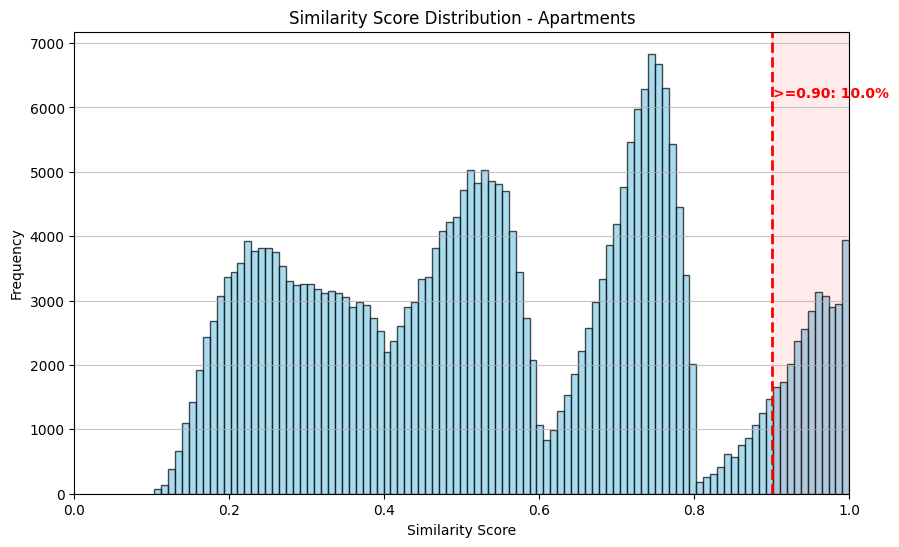

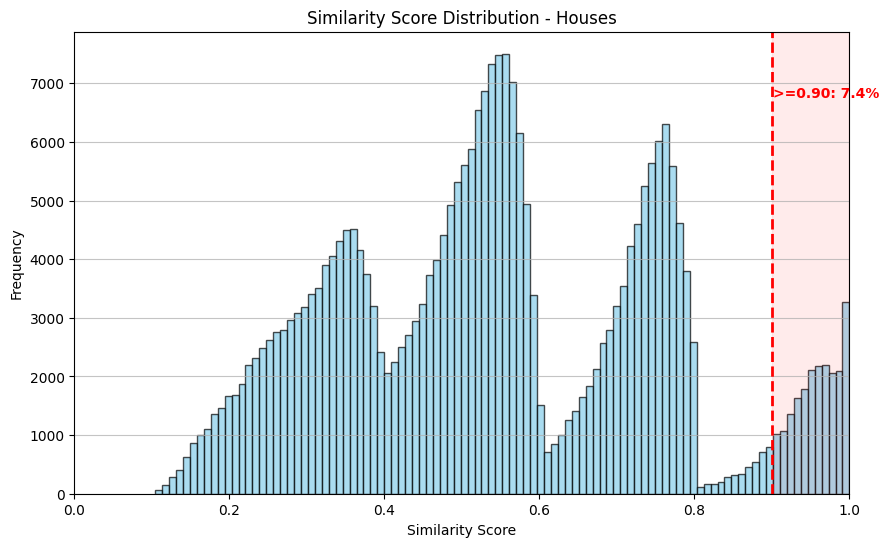

In [211]:
plot_score_distribution(df_neigh_apartments, bins=100, title="Similarity Score Distribution - Apartments")
plot_score_distribution(df_neigh_houses, bins=100, title="Similarity Score Distribution - Houses")

In [212]:
#getting the frequency column for apartments & houses
freq_col_apt= df_neigh_apartments["score"].hist(bin_count=100).rename({'breakpoint':'breakpoint_apt', 'category': 'category_apt', 'count': 'count_apt'})
freq_col_houses= df_neigh_houses["score"].hist(bin_count=100).rename({'breakpoint':'breakpoint_house', 'category': 'category_house', 'count': 'count_house'})
freq_col_houses.tail(5)

breakpoint_house,category_house,count_house
f64,cat,u32
0.964172,"""(0.955216, 0.964172]""",2173
0.973129,"""(0.964172, 0.973129]""",2202
0.982086,"""(0.973129, 0.982086]""",2065
0.991043,"""(0.982086, 0.991043]""",2094
1.0,"""(0.991043, 1.0]""",3274


In [213]:
#focusing only on the high scores
high_scores_apt = df_neigh_apartments.filter(pl.col("score") >= 0.9)
high_scores_house = df_neigh_houses.filter(pl.col("score") >= 0.9)

In [214]:
high_scores_apt.head(10)

grid_id,id_left,id_right,h3_left,h3_right,s_price,s_m2built,s_m2terrain,m2_flags_left,m2_flags_right,s_no_bedrooms,s_no_full_bathrooms,s_neigh,s_block,score
i64,str,str,str,str,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
1,"""141593231""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.882353,1.0,1.0,1,1,1.0,1.0,1.0,1.0,0.988235
1,"""141808421""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.760941,0.988235,0.988235,1,1,1.0,1.0,1.0,1.0,0.973741
1,"""141949221""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.882353,1.0,1.0,1,1,1.0,1.0,1.0,1.0,0.988235
1,"""141949307""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.882353,1.0,1.0,1,1,1.0,1.0,1.0,1.0,0.988235
1,"""143024845""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.809524,0.708333,0.708333,1,1,1.0,1.0,1.0,1.0,0.922619
1,"""143024859""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.809524,0.708333,0.708333,1,1,1.0,1.0,1.0,1.0,0.922619
1,"""143024880""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.809524,0.708333,0.708333,1,1,1.0,1.0,1.0,1.0,0.922619
1,"""144380786""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.73913,0.708333,0.708333,1,1,1.0,1.0,1.0,1.0,0.91558
1,"""50531913""","""50584464""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.617647,0.823529,0.823529,1,1,1.0,1.0,1.0,1.0,0.926471


In [215]:
def plot_score_scatter_bin(
    df_scores: pl.DataFrame,
    *,
    score_col: str = "score",
    attribute_col: str = "s_price",
    bins: int = 50,
    title: str = " Scatter plot of Frequency & Similarity Score"
) -> None:
    
    scores = df_scores.select(pl.col(score_col)).to_series().to_list() or []
    prices = df_scores.select(pl.col(attribute_col)).to_series().to_list() or []

    plt.figure(figsize=(10, 6))
    plt.scatter(prices, scores, alpha=0.5, color='blue', edgecolors='w', s=50)
    plt.title(title)
    plt.xlabel(attribute_col)
    plt.ylabel('Similarity Score')
    plt.grid(True)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.9, 1.0)

    if scores and prices:
        slope= (max(scores) - min(scores))/(max(prices) - min(prices)) if max(prices) != min(prices) else 0
        intercept= min(scores) - slope * min(prices)
        plt.plot([min(prices), max(prices)], [slope * min(prices) + intercept, slope * max(prices) + intercept], color='orange', linestyle='--', linewidth=2, label='Margin Line')

    # binning for trend line
    if scores and prices:
        bin_edges = np.linspace(min(prices), max(prices), bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_means = []
        for i in range(bins):
            bin_scores = [scores[j] for j in range(len(scores)) if bin_edges[i] <= prices[j] < bin_edges[i + 1]]
            if bin_scores:
                bin_means.append(np.mean(bin_scores))
            else:
                bin_means.append(np.nan)

        plt.plot(bin_centers, bin_means, color='red', linewidth=2, label='Binned Trend Line')
        plt.legend()
    
    plt.show()



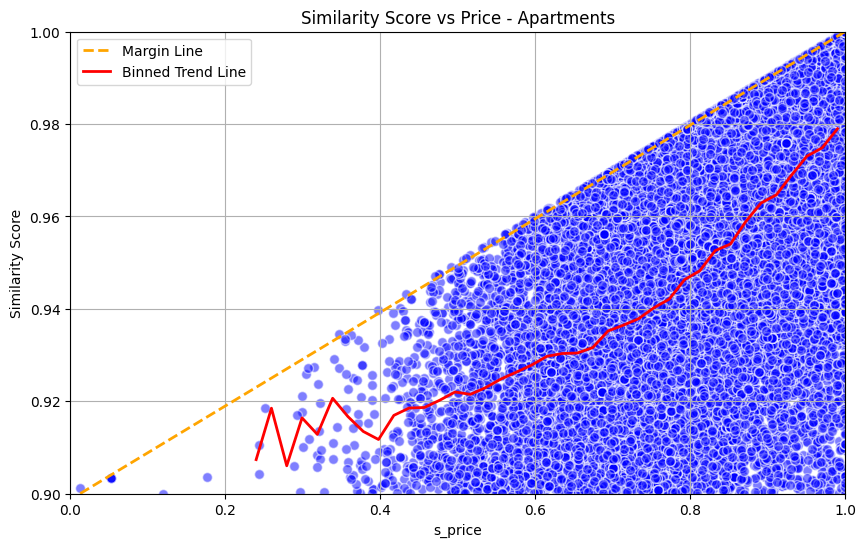

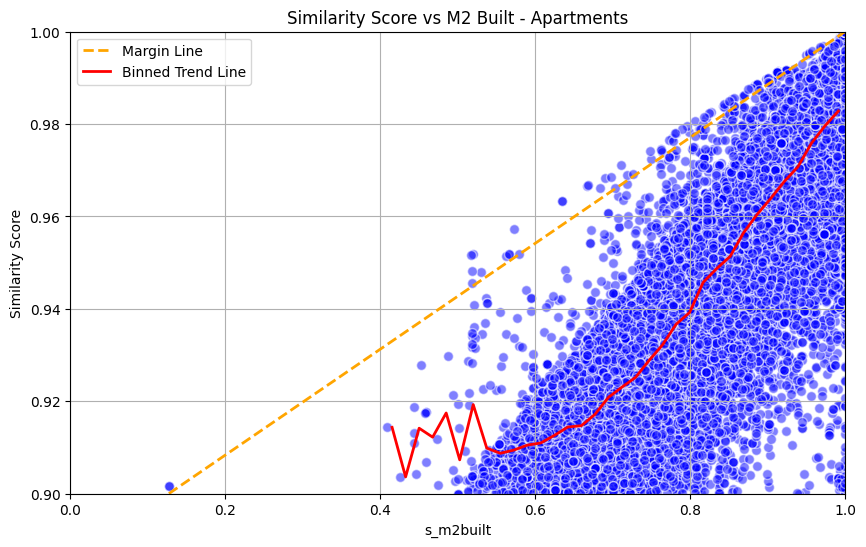

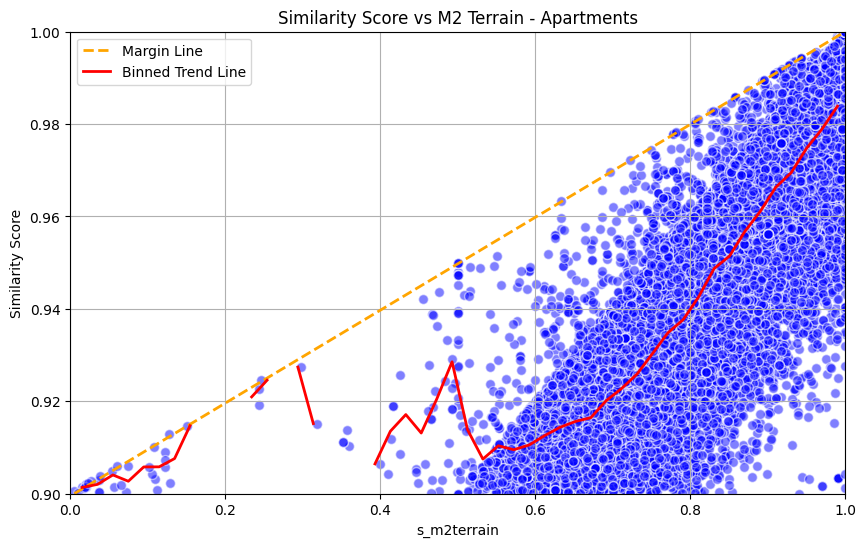

In [216]:
plot_score_scatter_bin(high_scores_apt, attribute_col="s_price", title="Similarity Score vs Price - Apartments")
plot_score_scatter_bin(high_scores_apt, attribute_col="s_m2built", title="Similarity Score vs M2 Built - Apartments")
plot_score_scatter_bin(high_scores_apt, attribute_col="s_m2terrain", title="Similarity Score vs M2 Terrain - Apartments")

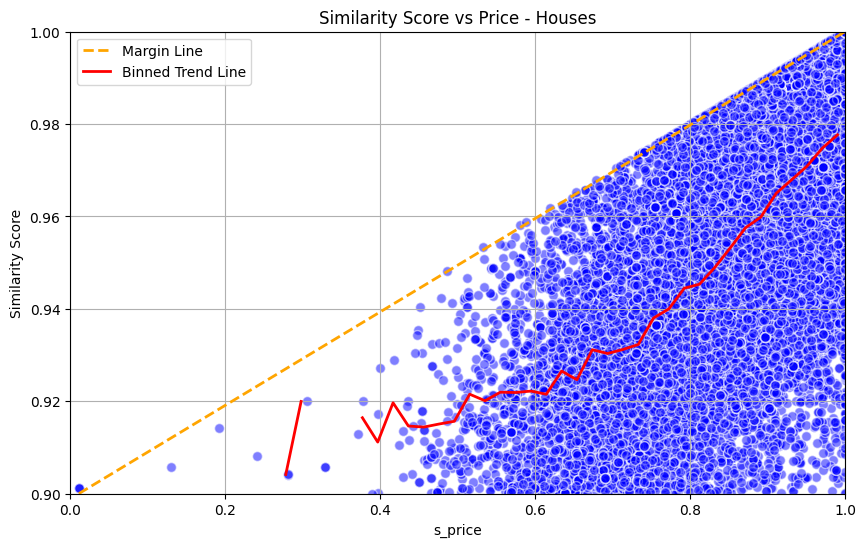

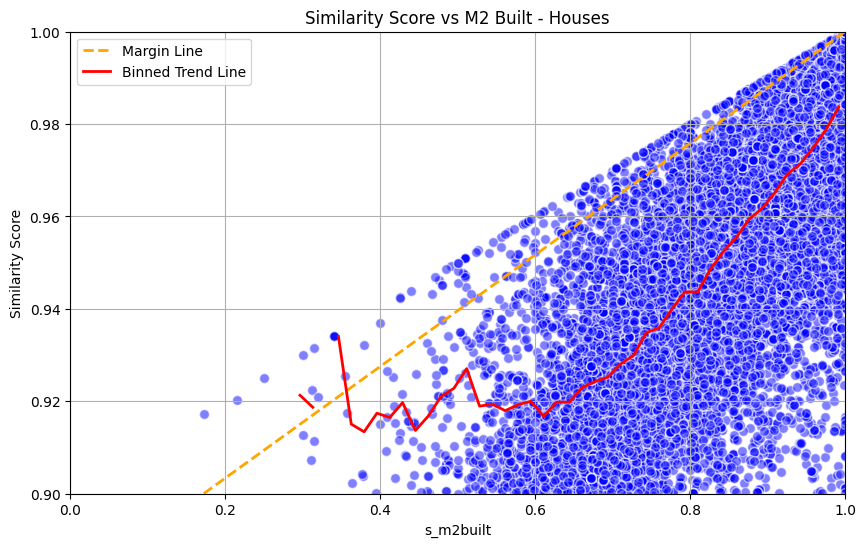

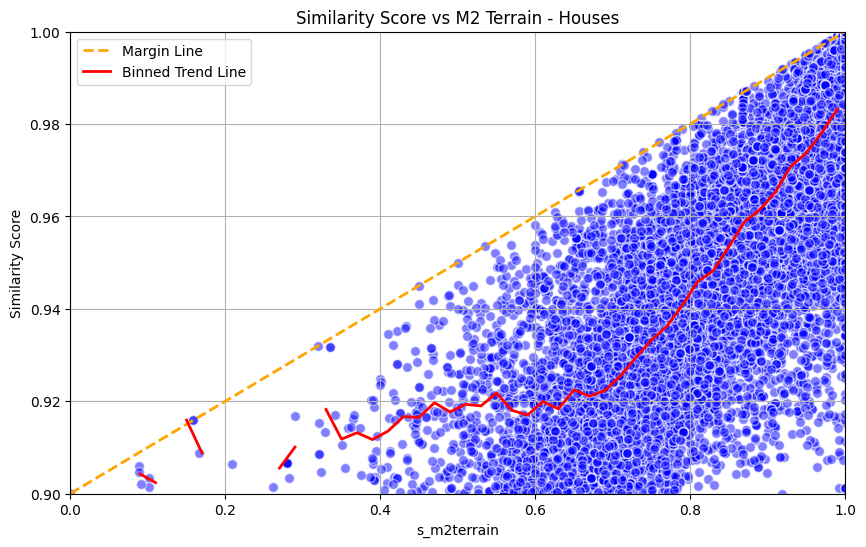

In [217]:
plot_score_scatter_bin(high_scores_house, attribute_col="s_price", title="Similarity Score vs Price - Houses")
plot_score_scatter_bin(high_scores_house, attribute_col="s_m2built", title="Similarity Score vs M2 Built - Houses")
plot_score_scatter_bin(high_scores_house, attribute_col="s_m2terrain", title="Similarity Score vs M2 Terrain - Houses")

## .

<h2 style="text-align: center;">TUNNING</h2>

## .

In [218]:
tolerance = 0.85
df_ap_tun1= high_scores_apt.filter(pl.col("s_price")>=tolerance).filter(pl.col("s_m2built")>=tolerance).filter(pl.col("s_m2terrain")>=tolerance)
df_hous_tun1= high_scores_house.filter(pl.col("s_price")>=tolerance).filter(pl.col("s_m2built")>=tolerance).filter(pl.col("s_m2terrain")>=tolerance)

In [219]:
df_ap_tun1

grid_id,id_left,id_right,h3_left,h3_right,s_price,s_m2built,s_m2terrain,m2_flags_left,m2_flags_right,s_no_bedrooms,s_no_full_bathrooms,s_neigh,s_block,score
i64,str,str,str,str,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
1,"""141593231""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.882353,1.0,1.0,1,1,1.0,1.0,1.0,1.0,0.988235
1,"""141949221""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.882353,1.0,1.0,1,1,1.0,1.0,1.0,1.0,0.988235
1,"""141949307""","""50531913""","""894995ba8d3ffff""","""894995ba8d3ffff""",0.882353,1.0,1.0,1,1,1.0,1.0,1.0,1.0,0.988235
3,"""144646783""","""50863178""","""894983cf2b3ffff""","""894983cf2b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""143384166""","""50911806""","""89499586b63ffff""","""89499586b63ffff""",0.957447,0.925,0.925,1,1,1.0,1.0,1.0,1.0,0.980745
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
67,"""145782162""","""145838301""","""896d34da80bffff""","""896d34da80bffff""",0.940476,1.0,1.0,1,1,1.0,1.0,1.0,1.0,0.994048
67,"""144340891""","""145838311""","""896d34da817ffff""","""896d34da817ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
67,"""144996094""","""145838311""","""896d34da817ffff""","""896d34da817ffff""",0.856734,1.0,1.0,1,1,1.0,1.0,1.0,1.0,0.985673


In [220]:
#df_ap_tun2 - only score == 1
df_ap_tun2= df_ap_tun1.filter(pl.col("score")==1)
counter1= df_ap_tun2.select(pl.col("grid_id").value_counts(sort=True))


In [221]:
df_ap_tun2

grid_id,id_left,id_right,h3_left,h3_right,s_price,s_m2built,s_m2terrain,m2_flags_left,m2_flags_right,s_no_bedrooms,s_no_full_bathrooms,s_neigh,s_block,score
i64,str,str,str,str,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
3,"""144646783""","""50863178""","""894983cf2b3ffff""","""894983cf2b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""51258969""","""51300428""","""894995ba8c3ffff""","""894995ba8c3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""51338189""","""51338212""","""894995ba8c3ffff""","""894995ba8c3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""51506043""","""51602259""","""894995ba8c3ffff""","""894995ba8c3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""141593231""","""54186989""","""894995ba8d3ffff""","""894995ba8d3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
274,"""145029019""","""145833248""","""89456da24bbffff""","""89456da24bbffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
613,"""145431044""","""145835533""","""894983c112fffff""","""894983c112fffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
67,"""144340891""","""145838311""","""896d34da817ffff""","""896d34da817ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0


In [222]:
#obtaining ids that sow up more than once with a perfect similarity score
#counter2=df_ap_tun2.select(pl.col("id_right").value_counts(sort=True))
threshold= 1
df_ap_tun3 = df_ap_tun2.filter(pl.col("id_left").count().over("id_left") > threshold)
df_ap_tun3

grid_id,id_left,id_right,h3_left,h3_right,s_price,s_m2built,s_m2terrain,m2_flags_left,m2_flags_right,s_no_bedrooms,s_no_full_bathrooms,s_neigh,s_block,score
i64,str,str,str,str,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
1,"""51258969""","""51300428""","""894995ba8c3ffff""","""894995ba8c3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""51506043""","""51602259""","""894995ba8c3ffff""","""894995ba8c3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""141593231""","""54186989""","""894995ba8d3ffff""","""894995ba8d3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""141949221""","""54186989""","""894995ba8d3ffff""","""894995ba8d3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""141949307""","""54186989""","""894995ba8d3ffff""","""894995ba8d3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
13,"""141891167""","""145768984""","""89498c96d37ffff""","""89498c96d37ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""145718003""","""145794141""","""8949958591bffff""","""8949958591bffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""145718003""","""145794148""","""8949958591bffff""","""8949958591bffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0


In [223]:
counter2=df_ap_tun3.select(pl.col("id_left").value_counts(sort=True))
counter2

id_left
struct[2]
"{""142445190"",10}"
"{""142445191"",9}"
"{""142819247"",8}"
"{""144673306"",8}"
"{""143030088"",7}"
…
"{""145686542"",2}"
"{""145630621"",2}"
"{""145751074"",2}"


In [224]:
df_ap_tun3.filter(pl.col("id_left") == "142445190")

grid_id,id_left,id_right,h3_left,h3_right,s_price,s_m2built,s_m2terrain,m2_flags_left,m2_flags_right,s_no_bedrooms,s_no_full_bathrooms,s_neigh,s_block,score
i64,str,str,str,str,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
1,"""142445190""","""142445191""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""142445190""","""144673306""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""142445190""","""144673309""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""142445190""","""144673326""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""142445190""","""144673327""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""142445190""","""144673330""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""142445190""","""144673332""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""142445190""","""144673335""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0
1,"""142445190""","""144673339""","""894995b85b3ffff""","""894995b85b3ffff""",1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0


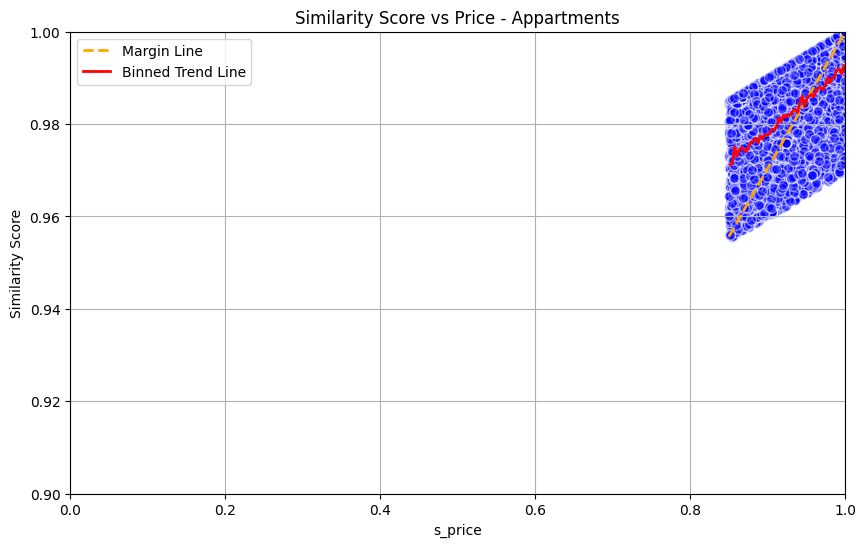

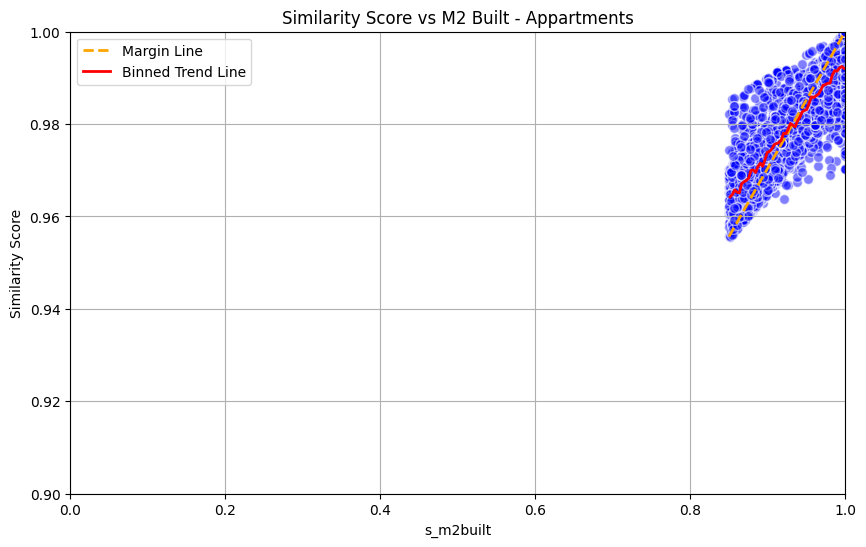

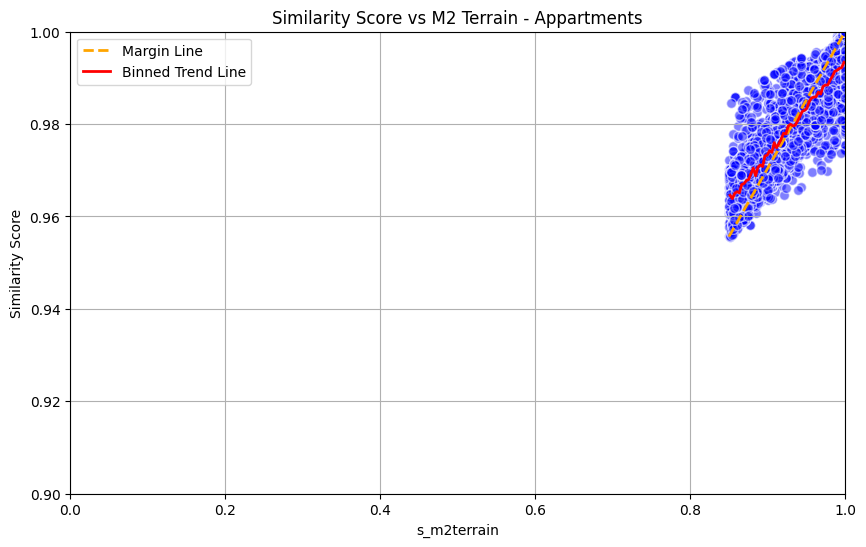

In [225]:
plot_score_scatter_bin(df_ap_tun1, attribute_col="s_price", title="Similarity Score vs Price - Appartments")
plot_score_scatter_bin(df_ap_tun1, attribute_col="s_m2built", title="Similarity Score vs M2 Built - Appartments")
plot_score_scatter_bin(df_ap_tun1, attribute_col="s_m2terrain", title="Similarity Score vs M2 Terrain - Appartments")

<h2 style="text-align: center;">OLD APPROACH (DO NOT RUN FOR LOW RES)</h2>

## .

In [226]:
def similarity_pairs_within_grid(
    df_input: pl.DataFrame,
    *,
    m2b_col: str = "m2_built",
    m2t_col: str = "m2_terrain",
    beds_col: str = "no_bedrooms",
    baths_col: str = "no_full_bathrooms",
    mflags_col: str = "m2_flags",
    id_col: str = "id",
    block_col: str = "block_id",
    grid_col: str = "grid_id",
    neigh_col: str = "neighbourhood_id",
    price_col: str = "price_mxn",
    hex_col: str = "h3_index",
    weights: dict[str, float] | None = None,
) -> pl.DataFrame:

    w = weights or {
        m2b_col: 1.0,
        m2t_col: 1.0,
        beds_col: 1.0,
        baths_col: 1.0,
        price_col: 1.0,
        neigh_col: 3.0,
        id_col: 2.0,  
    }

    base = df_input.select([
        pl.col(id_col).cast(pl.Utf8, strict=False).alias("id"),
        pl.col(block_col).cast(pl.Int64, strict=False).alias("block_id"),
        pl.col(m2b_col).cast(pl.Float64, strict=False).alias("m2_built"),
        pl.col(m2t_col).cast(pl.Float64, strict=False).alias("m2_terrain"),
        pl.col(beds_col).cast(pl.Float64, strict=False).alias("no_bedrooms"),
        pl.col(baths_col).cast(pl.Float64, strict=False).alias("no_full_bathrooms"),
        pl.col(mflags_col).cast(pl.Int64, strict=False).alias("m2_flags"),
        pl.col(grid_col).cast(pl.Int64, strict=False).alias("grid_id"),
        pl.col(neigh_col).cast(pl.Int64, strict=False).alias("neighbourhood_id"),
        pl.col(price_col).cast(pl.Float64, strict=False).alias("price_mxn"),
        pl.col(hex_col).cast(pl.String, strict=False).alias("h3_index"),
    ])

    left = base.rename({
        "id": "id_left",
        "block_id": "block_left",
        "price_mxn": "price_left",
        "m2_built": "m2_built_left",
        "m2_terrain": "m2_terrain_left",
        "no_bedrooms": "no_bedrooms_left",
        "no_full_bathrooms": "no_full_bathrooms_left",
        "m2_flags": "m2_flags_left",
        "neighbourhood_id": "neigh_id_left",
        "h3_index": "h3_left",
    })
    right = base.rename({
        "id": "id_right",
        "block_id": "block_right",
        "price_mxn": "price_right",
        "m2_built": "m2_built_right",
        "m2_terrain": "m2_terrain_right",
        "no_bedrooms": "no_bedrooms_right",
        "no_full_bathrooms": "no_full_bathrooms_right",
        "m2_flags": "m2_flags_right",
        "neighbourhood_id": "neigh_id_right",
        "h3_index": "h3_right",
    })

    pairs = (
        left.join(right, on="grid_id", how="inner")
            .filter(pl.col("id_left") < pl.col("id_right"))
    )

    # helper for similarity in [0,1]
    def sim_ratio(a: str, b: str) -> pl.Expr:
        return (
            1.0
            - ((pl.col(a) - pl.col(b)).abs()
               / pl.max_horizontal(pl.col(a).abs(), pl.col(b).abs(), pl.lit(1.0))
              ).clip(0.0, 1.0)
        ).fill_null(0.0)

    pairs = pairs.with_columns([
        pl.lit(1.0).alias("s_grid"),

        sim_ratio("price_left", "price_right").alias("s_price"),
        sim_ratio("m2_built_left", "m2_built_right").alias("s_m2built"),
        sim_ratio("m2_terrain_left", "m2_terrain_right").alias("s_m2terrain"),
        sim_ratio("no_bedrooms_left", "no_bedrooms_right").alias("s_no_bedrooms"),
        sim_ratio("no_full_bathrooms_left", "no_full_bathrooms_right").alias("s_no_full_bathrooms"),

        pl.when(pl.col("neigh_id_left") == pl.col("neigh_id_right"))
          .then(pl.lit(1.0))
          .otherwise(pl.lit(0.5))
          .alias("s_neigh"),

        pl.when(pl.col("block_left") == pl.col("block_right"))
          .then(pl.lit(1.0))
          .otherwise(pl.lit(0.0))
          .alias("s_block"),
    ])

    twsum = float(sum(float(w.get(k, 0.0)) for k in [m2b_col, m2t_col, price_col, beds_col, baths_col, neigh_col, id_col]))
    if twsum == 0:
        raise ValueError("Total weight sum is 0. Provide non-zero weights.")

    pairs = pairs.with_columns(
        (
            (
                pl.lit(w.get(m2b_col, 0.0))   * pl.col("s_m2built")
                + pl.lit(w.get(m2t_col, 0.0)) * pl.col("s_m2terrain")
                + pl.lit(w.get(price_col, 0.0)) * pl.col("s_price")
                + pl.lit(w.get(beds_col, 0.0))  * pl.col("s_no_bedrooms")
                + pl.lit(w.get(baths_col, 0.0)) * pl.col("s_no_full_bathrooms")
                + pl.lit(w.get(neigh_col, 0.0)) * pl.col("s_neigh")
                + pl.lit(w.get(id_col, 0.0))    * pl.col("s_block")
            ) / pl.lit(twsum)
        ).alias("score")
    )

    return pairs.select([
        "grid_id", "id_left", "id_right", "h3_left", "h3_right", "score",
        "s_price", "s_m2built", "s_m2terrain",
        "s_no_bedrooms", "s_no_full_bathrooms",
        "s_neigh", "s_block"
    ])


In [227]:
df_t8.head(2)

id,lat,lon,property_type,m2_built,m2_terrain,no_bedrooms,no_full_bathrooms,currency,m2_flags,h3_index,block_id,grid_id,neighbourhood_id,price_mxn
i64,f64,f64,str,f64,f64,f64,f64,str,f64,str,u32,i64,i64,f64
1077504,19.385515,-99.25333,"""Departamento""",290.0,290.0,3.0,3.0,"""MXN""",1.0,"""894995b1557ffff""",1,1,1,1.4e7
50481025,19.379354,-99.294898,"""Departamento""",145.0,145.0,2.0,3.0,"""MXN""",1.0,"""894995b00dbffff""",2,1,2,4.5e6


In [228]:
df_t9 = similarity_pairs_within_grid(df_t8)

In [229]:
df_t9.head(10)

grid_id,id_left,id_right,h3_left,h3_right,score,s_price,s_m2built,s_m2terrain,s_no_bedrooms,s_no_full_bathrooms,s_neigh,s_block
i64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
1,"""1077504""","""50481025""","""894995b1557ffff""","""894995b00dbffff""",0.44881,0.321429,0.5,0.5,0.666667,1.0,0.5,0.0
1,"""141468531""","""50481025""","""894995bac4bffff""","""894995b00dbffff""",0.508633,0.28125,0.819209,0.819209,1.0,0.666667,0.5,0.0
1,"""141469078""","""50481025""","""894995baeb3ffff""","""894995b00dbffff""",0.221875,0.0375,0.090625,0.090625,0.2,0.3,0.5,0.0
1,"""141470636""","""50481025""","""894995b1157ffff""","""894995b00dbffff""",0.402842,0.266272,0.297741,0.297741,0.666667,1.0,0.5,0.0
1,"""141477306""","""50481025""","""894995ba337ffff""","""894995b00dbffff""",0.4092,0.140845,0.54717,0.237316,0.666667,1.0,0.5,0.0
1,"""141477367""","""50481025""","""894995b1e07ffff""","""894995b00dbffff""",0.381835,0.25,0.325843,0.325843,0.666667,0.75,0.5,0.0
1,"""141480940""","""50481025""","""894995859a3ffff""","""894995b00dbffff""",0.530417,0.9375,0.6,0.6,1.0,0.666667,0.5,0.0
1,"""141481642""","""50481025""","""894995b130fffff""","""894995b00dbffff""",0.342959,0.236842,0.221374,0.221374,0.5,0.75,0.5,0.0
1,"""141484365""","""50481025""","""894995b31c7ffff""","""894995b00dbffff""",0.547427,0.376569,0.965517,0.965517,1.0,0.666667,0.5,0.0


## .

<h2 style="text-align: center;">---------[UP TO HERE]--------</h2>